# This notebook is for compiling the Jurassic Monster Shift data and for calculating the monster shift tracking using the current Bayesian statistical framwork

Goals of this work:
- To go through current published pmag and geochron data on poles during this Monster Shift period ~ (160 Ma to 140 Ma)
- Whether the published compilation work makes good sense
- Whether the Monster Shift (rapid shift rate) is real
- Whether the Monster Shift is a differential plate motion or TPW
- Using the Bayesian approach to assess whether the Monster Shift rate is indeed as fast as previously shown
- What is the mechanism that can cause either a rapid plate motion like this or a TPW under the paleogeographical framework during this time

In [5]:
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
import IPython
import pandas as pd
import matplotlib
import numpy as np
import numpy.polynomial.legendre as legendre
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import random
import copy
from scipy.stats import norm
from scipy.stats import halfnorm
from scipy.stats import skewnorm
from scipy.stats import vonmises
from scipy.stats import beta
from scipy.stats import gamma
import scipy.special as sps
from scipy.special import i0
import scipy.special as sc
from scipy.stats import truncnorm
from scipy.stats import uniform
from scipy.stats import poisson
import seaborn as sb
from scipy.constants import Julian_year
from scipy.special import erf, erfi

import pymc3 as pm
import pymc

import sys  
sys.path.insert(0, '../')
import mcplates

from pymc3 import distributions
from pymc3.distributions import Continuous, draw_values, generate_samples
import theano.tensor as T
from theano.compile.ops import as_op
from theano import shared
import theano
from pymc3.theanof import floatX

%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

In [ ]:
d2r = np.pi/180
r2d = 180/np.pi
eps = 1.e-6

In [ ]:
# function for finding a95 from dm and dp
def calc_a95(Im, dp, dm):
    Im = Im*d2r
    p = np.arctan(2/np.tan(Im))
    a95_dp = dp/(1+3*np.cos(p)**2)*2
    a95_dm = dm/np.sin(p)*np.cos(Im)

    print(a95_dp, a95_dm)
    return a95_dp, a95_dm

Let's create an empty dataframe that will be populated with pole means called 'pole_means'.

<b>PoleName | SLat | SLon | PLat | Plon | A95 | PolarityZone | PmagRef | AgeNominal | AgeLower | AgeUpper | AgeInfo | Q  </b>

<b>Pole_name</b> = Name of pole which corresponds to volcanic group <br>
<b>SLat</b> = Sample area decimal latitude (e.g. -56.2)<br>
<b>SLon</b> = Sample area decimal longitude (e.g. 134.8)<br>
<b>PLat</b> = Palaeomagnetic pole decimal latitude (e.g. -56.2)<br>
<b>PLon</b> = Palaeomagnetic pole decimal longitude (e.g. 134.8)<br>
<b>A95</b> = 95% confidence limit on pole in degrees (e.g. 6.2)<br>
<b>k</b> = Fisher precision parameter (e.g. 42.5)<br>
<b>N</b> = Number of VGPs used to calculate the mean<br>
<b>PolarityZone</b> = Assigned polarity zone<br>
<b>AgeNominal</b> = Mean / representative age of sampled formation (e.g. 1105.1)<br>
<b>AgeLower</b> = Estimate lower bound on age uncertainty (e.g. 1103.2)<br>
<b>AgeUpper</b> = Estimate upper bound on age uncertainty (e.g. 1107.4)<br>
<b>Gaussian_2sigma</b> = 2sigma error if Gaussian Distribution is to be used<br>
<b>GaussianOrUniform</b> = Distribution type used for Bayesian inversion<br>
<b>Q</b> = Van der Voo quality criteria (0 - 7)<br>

In [ ]:
pole_means = pd.DataFrame(columns=['PoleName','SLat','SLon','PLat','PLon',
                                   'A95','K','N','PolarityZone','PmagRef',
                                   'AgeNominal','AgeLower','AgeUpper',
                                   'AgeInfo','AgeRef','Gaussian_2sigma',
                                   'GaussianOrUniform','Q','color'])

## Jurassic Monster Shift pole compilation

In late Jurassic, global paleomagnetic records show rapid pole progression between ca. 160 Ma and ca. 145 Ma. The current configuration of the Monster Shift pole path is under debate. Kent (2010, 2015) argue that uncertainties in age, structural correlations, and directional data exclude many of the paleomagnetic poles included in Torsvik (2012). Also, inclination shallowing uncertainties in sedimentary data, structural correction uncertainties associated with the Colorado plateau (rotation) all play a role in the current compilations and causing different Monster Shift paths, leading to controversies in interpretations. 

The difference in pole choices and averaging result lead to significant interpretations between Kent (2015) and Torsvik (2012), with the Torsvik one much smoother and with a much smaller pole distance between 160 Ma and 140 Ma. Torsvik: 14.0􏰽 as in K&I: 26.7􏰽 degrees.



Reference:
Kent, D. V., B. A. Kjarsgaard, J. S. Gee,
G. Muttoni, and L. M. Heaman (2015), Tracking the Late Jurassic apparent (or true) polar shift in U-Pb-dated kimberlites from cratonic North America (Superior Province of Canada), Geochem. Geophys. Geosyst., 16, 983– 994, doi:10.1002/2015GC005734.

Muttoni, G., & Kent, D. V. (2019). Jurassic monster polar shift confirmed by sequential paleopoles from Adria, promontory of Africa. Journal of Geophysical Research: Solid Earth, 124, 3288–3306. https://doi.org/10.1029/2018JB017199. 

# North American Monster Shift records

## deBoer (1967) Dikes from the basaltic dikes (diabase) in the Appalachians

This is one of the early paleomagnetic studies of the intrusives in the Appalachian area focusing on the Mesozoic paleomagnetic pole position of NA. The dikes are steeply inclined with no preferred dip directions, and field observations show they are almost symmetrically dipped on both sides. This leads to interpretation that minimal post formation tilting happened, although a rotations along the dike planes cannot be rejected. Nevertheless, that the dike orientations are quite distributed in a variety of directions lend some support that there hasn't been significant regional tilting. 

The dikes are "narrow" from meters to a hundred meters in wide, thus was inferred as "narrow dikes" by Smith (1979). They are basaltic, augite-laboradorite in composition. Magnetite and ilmenite reported as both in skeletal crystals to subhedral to anhedral groundmass. 

The provided data table in the publication already grouped the 80 dikes collected into locations, specifically county level location under state locations. Although the groped site means have relatively low a95 in most "sites", this grouping method is nevertheless not ideal. Here we will use the provided directions and see whether they are a good grouping anyways by comparing to other data developed of similar age in similar region.


De Boer, J. (1967). Paleomagnetic‐tectonic study of Mesozoic dike swarms in the Appalachians. Journal of Geophysical Research, 72(8), 2237-2250. doi:10.1029/jz072i008p02237.

In [3]:
deBoer1967a_sites = pd.read_csv('pmag_compiled/deBoer1967a/deBoer1967a_sites.txt', sep = '\t', header = 1)
deBoer1967a_sites = ipmag.vgp_calc(deBoer1967a_sites,  tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
deBoer1967a_sites = deBoer1967a_sites[deBoer1967a_sites['dir_alpha95'] < 15]
deBoer1967a_sites

,site,location,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_total_specimens,dir_tilt_correction,dir_alpha95,...,age,age_high,age_low,age_unit,citations,paleolatitude,vgp_lat,vgp_lon,vgp_lat_rev,vgp_lon_rev
0,1,Piedmont,340,25,37,14,21,21,0,8,...,NaN,NaN,NaN,NaN,10.1029/jz072i008p02237,13.124268,62.679571,143.029768,-62.679571,323.029768
1,2,Deep River basin,342,31,26,26,48,48,0,7,...,NaN,NaN,NaN,NaN,10.1029/jz072i008p02237,16.721861,66.684929,148.895794,-66.684929,328.895794
2,3,Danville basin,333,32,31,8,15,15,0,12,...,NaN,NaN,NaN,NaN,10.1029/jz072i008p02237,17.350615,59.433336,158.942005,-59.433336,338.942005
4,5,Bent Creek + Warren basin + Nelson County + Fa...,340,36,44,22,37,37,0,6,...,NaN,NaN,NaN,NaN,10.1029/jz072i008p02237,19.964629,65.307297,151.810359,-65.307297,331.810359
5,6,Augusta County,347,37,65,7,13,13,0,8,...,NaN,NaN,NaN,NaN,10.1029/jz072i008p02237,20.645256,69.321495,137.592675,-69.321495,317.592675
6,7,Gettysburg basin,352,40,47,12,24,24,0,10,...,NaN,NaN,NaN,NaN,10.1029/jz072i008p02237,22.760476,71.477610,126.827479,-71.477610,306.827479
7,8,Newark basin,346,41,61,10,17,17,0,10,...,NaN,NaN,NaN,NaN,10.1029/jz072i008p02237,23.491856,69.316858,143.915493,-69.316858,323.915493
8,9,Connecticut state,343,38,107,16,39,39,0,7,...,NaN,NaN,NaN,NaN,10.1029/jz072i008p02237,21.337745,65.262951,148.601941,-65.262951,328.601941


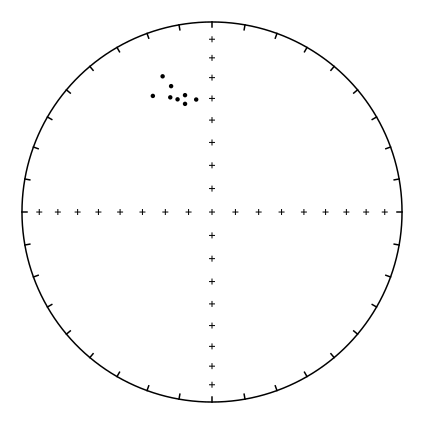

In [152]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(deBoer1967a_sites['dir_dec'].tolist(), deBoer1967a_sites['dir_inc'].tolist())

# plt.legend(loc = 8)
plt.show()

In [153]:
deBoer1967a_sites_vgp_mean = ipmag.fisher_mean(deBoer1967a_sites['vgp_lon'].tolist(),deBoer1967a_sites['vgp_lat'].tolist())
deBoer1967a_sites_vgp_mean

{'dec': 146.04658551728636,
 'inc': 66.43813496679239,
 'n': 8,
 'r': 7.968280949587526,
 'k': 220.68756501131375,
 'alpha95': 3.736928679746198,
 'csd': 5.4525051877389625}

143.91549322730293 69.31685767312004


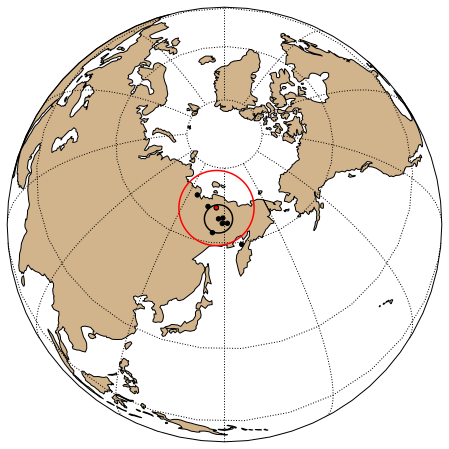

In [154]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,deBoer1967a_sites['vgp_lon'].tolist(),deBoer1967a_sites['vgp_lat'].tolist())
ipmag.plot_pole(map_axis,deBoer1967a_sites_vgp_mean['dec'],deBoer1967a_sites_vgp_mean['inc'], deBoer1967a_sites_vgp_mean['alpha95'])

for i in range(len(deBoer1967a_sites['vgp_lon'].tolist())):
    if deBoer1967a_sites['location'].tolist()[i] == 'Newark basin':
        print(deBoer1967a_sites['vgp_lon'].tolist()[i], deBoer1967a_sites['vgp_lat'].tolist()[i])
        ipmag.plot_pole(map_axis,deBoer1967a_sites['vgp_lon'].tolist()[i], deBoer1967a_sites['vgp_lat'].tolist()[i], 
                        deBoer1967a_sites['dir_alpha95'].tolist()[i], color = 'red')


plt.show()

Note this pole position is way too easterly when comparing to the pole position developed by Smith and Noltimier (1979) shown below. This may be attributed to the limited number of sites. However, considering a total of more than a hundered of samples were used and the site mean directions trend more easterly, this may also, very likely be interpreted as that the dikes in this study is distinct from the magmatism that emplaced those in Smith and Noltimier (1979) intrusives. In addition, the Newark basin one may be incorporated to the average directions for Smith and Noltimier (1979) compilation, since the pole position, considering the quite large a95, can be interpreted to be similar to that of the West Rock vgp. 

My current interpretation considering this tight cluster of 8 "sites" in this study which is more eaterly than those in the S & N (1979) and through comparison between these poles to the polar wander path by Gordon et al., 1984 and Irving and Irving 1982 as is shown in Kent & Irving (2010), that these dikes sampled in this study is likely of younger age than those from the S & N (1979). Unless a substantial structural corrections on all these dikes from all Appalachian area, which is unlikely given the field observations that the dips of the dikes are symmetric, the fact that these poles are far east than those from the Hartford Basin is likely indication of younger age. 

**The Ar/Ar dates of 173 Ma and 168 Ma reported by Sutter and Smith (1979) might be better age assignment for these dikes than those in S & N (1979).** 

## deBoer (1968) volcanics in the Central Appalachians (Connecticut Valley)

Paleomagnetic study similar to intrusives of Smith and Noltimier (1979); extrusives similar to Prevot (1989). 
Not site level data, just grouped data by location. No site location information, or good age constraints. All cited ages range from 190 Ma to 200 Ma.

The lack of site level data limit our ability to reproduce the grouping shown in Smith and Noltimier (1979). 

In [159]:
deBoer1968a_sites = pd.read_csv('pmag_compiled/deBoer1968a/deBoer1968a_sites.txt', sep = '\t', header = 1)
deBoer1968a_sites = deBoer1968a_sites[deBoer1968a_sites['dir_alpha95'] < 15]
deBoer1968a_sites

,site,location,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_total_specimens,dir_tilt_correction,dir_alpha95,...,method_codes,result_quality,result_type,age,age_high,age_low,age_unit,pole_lon,pole_lat,citations
0,1,Talcott,18,12,185,111,111,111,0,4,...,LT-AF-Z:DE-BLANKET,g,i,NaN,NaN,NaN,NaN,78,51,10.1029/jz072i008p02237
1,2,Holyoke,12,25,146,150,150,150,0,3,...,LT-AF-Z:DE-BLANKET,g,i,NaN,NaN,NaN,NaN,83,60,10.1029/jz072i008p02237
2,3,Hampden,4,43,102,146,146,146,0,4,...,LT-AF-Z:DE-BLANKET,g,i,NaN,NaN,NaN,NaN,92,73,10.1029/jz072i008p02237
3,4,West Rock,9,29,136,40,40,40,0,4,...,LT-AF-Z:DE-BLANKET,g,i,NaN,NaN,NaN,NaN,89,63,10.1029/jz072i008p02237
4,5,Hampden,0,49,34,54,54,54,0,7,...,LT-AF-Z:DE-BLANKET,g,i,NaN,NaN,NaN,NaN,106,79,10.1029/jz072i008p02237
5,6,Mt Carmel,10,26,32,67,67,67,0,4,...,LT-AF-Z:DE-BLANKET,g,i,NaN,NaN,NaN,NaN,87,61,10.1029/jz072i008p02237
6,7,Cheshire,1,47,31,41,41,41,0,4,...,LT-AF-Z:DE-BLANKET,g,i,NaN,NaN,NaN,NaN,103,76,10.1029/jz072i008p02237


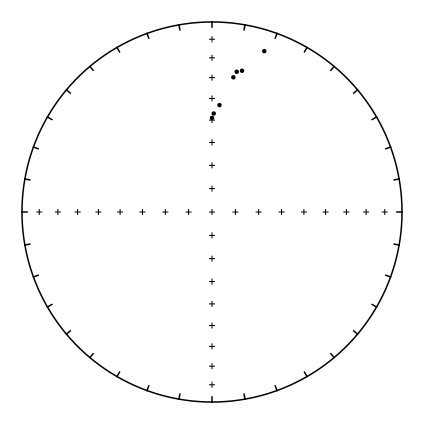

In [156]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(deBoer1968a_sites['dir_dec'].tolist(), deBoer1968a_sites['dir_inc'].tolist())

# plt.legend(loc = 8)
plt.show()

In [157]:
deBoer1968a_sites_vgp_mean = ipmag.fisher_mean(deBoer1968a_sites['pole_lon'].tolist(),deBoer1968a_sites['pole_lat'].tolist())
deBoer1968a_sites_vgp_mean

{'dec': 87.763130886251,
 'inc': 66.37330667217505,
 'n': 7,
 'r': 6.894990136853106,
 'k': 57.13748994803305,
 'alpha95': 8.05340850926027,
 'csd': 10.715796067074482}

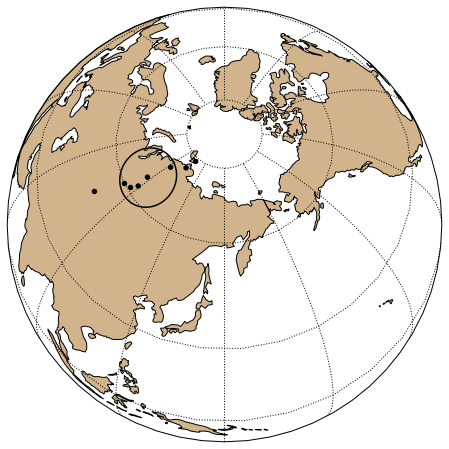

In [158]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,deBoer1968a_sites['pole_lon'].tolist(),deBoer1968a_sites['pole_lat'].tolist())
ipmag.plot_pole(map_axis,deBoer1968a_sites_vgp_mean['dec'],deBoer1968a_sites_vgp_mean['inc'], deBoer1968a_sites_vgp_mean['alpha95'])

plt.show()

## Smith and Noltimier (1979) intrusive rocks from Hartford Basin

This study is focusing on similar area as the previous two but instead of developing data from volcanics, this focuses on the intrusives in Hartford Basin. 28 sites from Early Mesozoic Barndoor, East Rock, Mt. Carmel, West Rock intrusives. The data table in the paper also include the Barndoor intrusives from Connecticut besides the aforementioned ones from New York.

The Barndoor East rock, Mt Carmel, and West rock units are intrusive bodies that outcrop in the New Haven formation of western side Hartford Basin. Barndoors has max thickness of 300 km where the other two has about 30 km thickness. Aeromagnetic data suggest these untis are conformable with host Paleozoic host rock with a dip of 20-30 degrees to the east-sourtheast. Here the confidence of doing the tilt correction is addressed both with aeromagentic and field observation that the intrusives were emplaced before the rotation of host rock. The tilt correection brings some site directions better clusters but overall they have pretty tight grouping. 

A total of 33 sites from 4 intrusives were sampled AF cleaning up to 25 mT were used for majority of directional analyses, while some set of samples were further AF demagnetized up to 100 mT and thermally demagnetized up to 600 degree C for magnetic characteristics investigations. Selection criteria were applied to the results, one of them is worth noting here that they exclude sites that have **a95 > 10 degree** which is quite strict. However, it is nice that they provide all data including those with large uncertainties. So here we try to use criteria **a95 < 15**

Af demag suggest presence of MD or PSD grains with present day overprint; unblocking temperature around 500-600 degree c suggest Fe-Ti oxides as remanence carriers, and sharp decrease in magnetization after 450 step was interpreted to be indication of Fe-Ti oxides breakdown after this temperature. Opaque microscopy see Fe-Ti oxides, which supports rock magnetic interpretations.

This study also mentioned many early paleomagnetic studies from the Newark trend and they might be of interest for compilation work here. These data are considered to be associated with the time period when the Central Atlantic Ocean began to open. 

Smith, T. E., & Noltimier, H. C. (1979). Paleomagnetism of the Newark Trend igneous rocks of the north central Appalachians and the opening of the central Atlantic Ocean. American Journal of Science, 279(7), 778-807. doi: 10.2475/ajs.279.7.778. 

In [84]:
Smith1985a_sites = pd.read_csv('pmag_compiled/Smith1979a/Smith1979a_sites.txt', sep = '\t', header = 1)
Smith1985a_sites = Smith1985a_sites[Smith1985a_sites['dir_alpha95'] < 15]
Smith1985a_sites = ipmag.vgp_calc(Smith1985a_sites, tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Smith1985a_sites

,site,location,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_total_specimens,dir_tilt_correction,dir_alpha95,...,age_low,age_unit,dir_dip,dip,citations,paleolatitude,vgp_lat,vgp_lon,vgp_lat_rev,vgp_lon_rev
0,WR-1,West Rock,14.5,31.7,75,6,6,6,0,7.8,...,NaN,NaN,120,20,10.2475/ajs.279.7.778,17.161017,62.809010,75.460419,-62.809010,255.460419
1,WR-2,West Rock,354.0,19.1,354,8,8,8,0,2.9,...,NaN,NaN,120,20,10.2475/ajs.279.7.778,9.822839,58.011991,118.241249,-58.011991,298.241249
2,WR-3,West Rock,359.6,26.0,178,9,9,9,0,3.9,...,NaN,NaN,120,20,10.2475/ajs.279.7.778,13.705006,62.332814,108.056943,-62.332814,288.056943
3,WR-4,West Rock,358.6,27.0,131,10,10,10,0,4.2,...,NaN,NaN,120,20,10.2475/ajs.279.7.778,14.292786,62.885488,110.027687,-62.885488,290.027687
6,WR-7,West Rock,347.6,31.1,62,7,7,7,0,7.7,...,NaN,NaN,120,20,10.2475/ajs.279.7.778,16.784324,63.172493,134.169591,-63.172493,314.169591
7,WR-8,West Rock,356.4,31.8,806,8,8,8,0,1.9,...,NaN,NaN,120,20,10.2475/ajs.279.7.778,17.224123,65.627083,115.426488,-65.627083,295.426488
8,WR-9,West Rock,356.0,24.8,315,13,13,13,0,2.3,...,NaN,NaN,120,20,10.2475/ajs.279.7.778,13.008934,61.395142,115.231340,-61.395142,295.231340
11,WR-12,West Rock,344.9,38.4,134,9,9,9,0,4.5,...,NaN,NaN,120,25,10.2475/ajs.279.7.778,21.618181,66.375082,144.280065,-66.375082,324.280065
12,ER-1,East Rock,6.2,27.3,261,14,14,14,0,2.5,...,NaN,NaN,120,25,10.2475/ajs.279.7.778,14.470548,62.586661,93.921700,-62.586661,273.921700
13,ER-2,East Rock,354.7,28.0,205,12,12,12,0,3.0,...,NaN,NaN,120,25,10.2475/ajs.279.7.778,14.887976,63.141909,118.446329,-63.141909,298.446329


In [85]:
Smith1985a_sites_WR = Smith1985a_sites[Smith1985a_sites['location'] == 'West Rock']
Smith1985a_sites_ER = Smith1985a_sites[Smith1985a_sites['location'] == 'East Rock']
Smith1985a_sites_Carmel = Smith1985a_sites[Smith1985a_sites['location'] == 'Carmel']
Smith1985a_sites_Barndoor = Smith1985a_sites[Smith1985a_sites['location'] == 'Barndoor']

,site,location,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_total_specimens,dir_tilt_correction,dir_alpha95,...,age_low,age_unit,dir_dip,dip,citations,paleolatitude,vgp_lat,vgp_lon,vgp_lat_rev,vgp_lon_rev
22,BD-1,Barndoor,7.9,34.9,118,10,10,10,0,4.5,...,NaN,NaN,120,25,10.2475/ajs.279.7.778,19.229018,66.290983,88.390486,-66.290983,268.390486
23,BD-2,Barndoor,3.2,28.9,101,11,11,11,0,4.6,...,NaN,NaN,110,15,10.2475/ajs.279.7.778,15.430295,63.337210,100.312944,-63.337210,280.312944
24,BD-3,Barndoor,14.7,31.9,424,11,11,11,0,2.2,...,NaN,NaN,110,20,10.2475/ajs.279.7.778,17.287322,62.385779,75.614284,-62.385779,255.614284
25,BD-4,Barndoor,11.5,22.4,59,6,6,6,0,7.4,...,NaN,NaN,110,20,10.2475/ajs.279.7.778,11.644779,58.147740,85.413902,-58.147740,265.413902
26,BD-5,Barndoor,356.8,31.2,78,8,8,8,0,6.3,...,NaN,NaN,120,20,10.2475/ajs.279.7.778,16.846877,64.876373,114.358935,-64.876373,294.358935
27,BD-6,Barndoor,6.1,32.9,29,9,9,9,0,9.7,...,NaN,NaN,120,20,10.2475/ajs.279.7.778,17.924553,65.542877,92.994794,-65.542877,272.994794
28,BD-7,Barndoor,358.7,28.3,857,8,8,8,0,1.9,...,NaN,NaN,120,20,10.2475/ajs.279.7.778,15.068034,63.224467,109.917349,-63.224467,289.917349
29,BD-8,Barndoor,10.6,37.7,56,8,8,8,0,7.4,...,NaN,NaN,120,20,10.2475/ajs.279.7.778,21.128721,67.463485,80.534806,-67.463485,260.534806
30,BD-9,Barndoor,1.9,40.6,132,5,5,5,0,6.7,...,NaN,NaN,120,20,10.2475/ajs.279.7.778,23.197642,71.310189,101.672860,-71.310189,281.672860
31,BD-10,Barndoor,355.9,29.6,77,9,9,9,0,5.9,...,NaN,NaN,120,20,10.2475/ajs.279.7.778,15.856642,63.797558,116.091131,-63.797558,296.091131


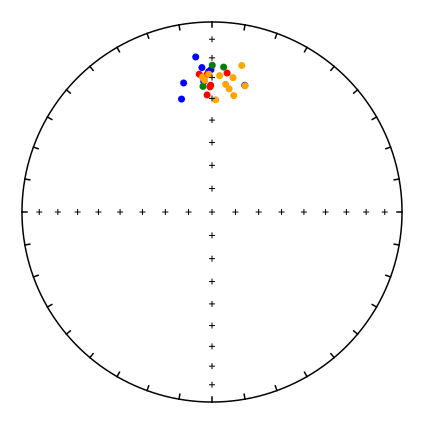

In [86]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Smith1985a_sites_WR['dir_dec'].tolist(), Smith1985a_sites_WR['dir_inc'].tolist(), color = 'blue', markersize = 50)
ipmag.plot_di(Smith1985a_sites_ER['dir_dec'].tolist(), Smith1985a_sites_ER['dir_inc'].tolist(), color = 'red', markersize = 50)
ipmag.plot_di(Smith1985a_sites_Carmel['dir_dec'].tolist(), Smith1985a_sites_Carmel['dir_inc'].tolist(), color = 'green', markersize = 50)
ipmag.plot_di(Smith1985a_sites_Barndoor['dir_dec'].tolist(), Smith1985a_sites_Barndoor['dir_inc'].tolist(), color = 'orange', markersize = 50)

# ipmag.plot_di_mean(Larochelle1971a_site_mean['dir_dec'][0], Larochelle1971a_site_mean['dir_inc'][0], 1.04, color = 'blue', label = 'Larochelle, 1971 2 dikes')

# plt.legend(loc = 8)
plt.show()

In [87]:
Smith1985a_sites_WR_vgp_mean = ipmag.fisher_mean(Smith1985a_sites_WR['vgp_lon'].tolist(),Smith1985a_sites_WR['vgp_lat'].tolist())
Smith1985a_sites_ER_vgp_mean = ipmag.fisher_mean(Smith1985a_sites_ER['vgp_lon'].tolist(),Smith1985a_sites_ER['vgp_lat'].tolist())
Smith1985a_sites_Carmel_vgp_mean = ipmag.fisher_mean(Smith1985a_sites_Carmel['vgp_lon'].tolist(),Smith1985a_sites_Carmel['vgp_lat'].tolist())
Smith1985a_sites_Barndoor_vgp_mean = ipmag.fisher_mean(Smith1985a_sites_Barndoor['vgp_lon'].tolist(),Smith1985a_sites_Barndoor['vgp_lat'].tolist())

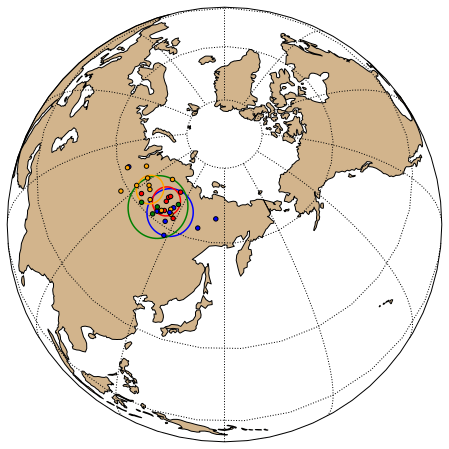

In [88]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Smith1985a_sites_WR['vgp_lon'].tolist(),Smith1985a_sites_WR['vgp_lat'].tolist(), color = 'blue')
ipmag.plot_vgp(map_axis,Smith1985a_sites_ER['vgp_lon'].tolist(),Smith1985a_sites_ER['vgp_lat'].tolist(), color = 'red')
ipmag.plot_vgp(map_axis,Smith1985a_sites_Carmel['vgp_lon'].tolist(),Smith1985a_sites_Carmel['vgp_lat'].tolist(), color = 'green')
ipmag.plot_vgp(map_axis,Smith1985a_sites_Barndoor['vgp_lon'].tolist(),Smith1985a_sites_Barndoor['vgp_lat'].tolist(), color = 'orange')


ipmag.plot_pole(map_axis, Smith1985a_sites_WR_vgp_mean['dec'], Smith1985a_sites_WR_vgp_mean['inc'], 
                Smith1985a_sites_WR_vgp_mean['alpha95'], color = 'blue')
ipmag.plot_pole(map_axis, Smith1985a_sites_ER_vgp_mean['dec'], Smith1985a_sites_ER_vgp_mean['inc'], 
                Smith1985a_sites_ER_vgp_mean['alpha95'], color = 'red')
ipmag.plot_pole(map_axis, Smith1985a_sites_Carmel_vgp_mean['dec'], Smith1985a_sites_Carmel_vgp_mean['inc'], 
                Smith1985a_sites_Carmel_vgp_mean['alpha95'], color = 'green')
ipmag.plot_pole(map_axis, Smith1985a_sites_Barndoor_vgp_mean['dec'], Smith1985a_sites_Barndoor_vgp_mean['inc'], 
                Smith1985a_sites_Barndoor_vgp_mean['alpha95'], color = 'orange')
plt.show()

Above plots show the raw data from Smith (1983) showing that without structural corrections the pole from the intrusives is very close to those derived from the volcanics, see McIntosh1985 section and Prevot1989 section. Below we will show the structurally corrected directions and pole positions and see how this affect the data. 

In [100]:
pmag.dotilt(Smith1985a_sites['dir_dec'].tolist()[1], Smith1985a_sites['dir_inc'].tolist()[1], Smith1985a_sites['dir_dip'][1],  Smith1985a_sites['dip'][1])[0]
                                

1.7938800574404563

In [103]:
Smith1985a_sites['dec_tc'] = [pmag.dotilt(Smith1985a_sites['dir_dec'].tolist()[i], Smith1985a_sites['dir_inc'].tolist()[i], 
                                          Smith1985a_sites['dir_dip'].tolist()[i],  Smith1985a_sites['dip'].tolist()[i])[0]
                                      for i in range(len(Smith1985a_sites['dir_dec']))]
Smith1985a_sites['inc_tc'] = [pmag.dotilt(Smith1985a_sites['dir_dec'].tolist()[i], Smith1985a_sites['dir_inc'].tolist()[i], 
                                          Smith1985a_sites['dir_dip'].tolist()[i],  Smith1985a_sites['dip'].tolist()[i])[1] 
                                      for i in range(len(Smith1985a_sites['dir_dec']))]
# Smith1985a_sites
Smith1985a_sites_tilt_corrected = ipmag.vgp_calc(Smith1985a_sites, tilt_correction='yes',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc',
    dec_tc='dec_tc',
    inc_tc='inc_tc')

In [105]:
Smith1985a_sites_WR_tilt_corrected = Smith1985a_sites_tilt_corrected[Smith1985a_sites_tilt_corrected['location'] == 'West Rock']
Smith1985a_sites_ER_tilt_corrected = Smith1985a_sites_tilt_corrected[Smith1985a_sites_tilt_corrected['location'] == 'East Rock']
Smith1985a_sites_Carmel_tilt_corrected = Smith1985a_sites_tilt_corrected[Smith1985a_sites_tilt_corrected['location'] == 'Carmel']
Smith1985a_sites_Barndoor_tilt_corrected = Smith1985a_sites_tilt_corrected[Smith1985a_sites_tilt_corrected['location'] == 'Barndoor']

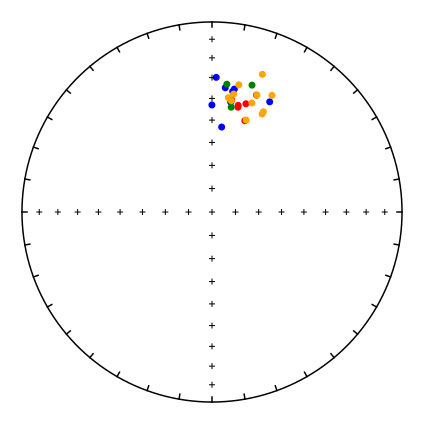

In [106]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Smith1985a_sites_WR_tilt_corrected['dec_tc'].tolist(), Smith1985a_sites_WR_tilt_corrected['inc_tc'].tolist(), color = 'blue', markersize = 50)
ipmag.plot_di(Smith1985a_sites_ER_tilt_corrected['dec_tc'].tolist(), Smith1985a_sites_ER_tilt_corrected['inc_tc'].tolist(), color = 'red', markersize = 50)
ipmag.plot_di(Smith1985a_sites_Carmel_tilt_corrected['dec_tc'].tolist(), Smith1985a_sites_Carmel_tilt_corrected['inc_tc'].tolist(), color = 'green', markersize = 50)
ipmag.plot_di(Smith1985a_sites_Barndoor_tilt_corrected['dec_tc'].tolist(), Smith1985a_sites_Barndoor_tilt_corrected['inc_tc'].tolist(), color = 'orange', markersize = 50)

# ipmag.plot_di_mean(Larochelle1971a_site_mean['dir_dec'][0], Larochelle1971a_site_mean['dir_inc'][0], 1.04, color = 'blue', label = 'Larochelle, 1971 2 dikes')

# plt.legend(loc = 8)
plt.show()

In [110]:
Smith1985a_sites_WR_vgp_mean_tc = ipmag.fisher_mean(Smith1985a_sites_WR_tilt_corrected['vgp_lon'].tolist(),Smith1985a_sites_WR_tilt_corrected['vgp_lat'].tolist())
Smith1985a_sites_ER_vgp_mean_tc = ipmag.fisher_mean(Smith1985a_sites_ER_tilt_corrected['vgp_lon'].tolist(),Smith1985a_sites_ER_tilt_corrected['vgp_lat'].tolist())
Smith1985a_sites_Carmel_vgp_mean_tc = ipmag.fisher_mean(Smith1985a_sites_Carmel_tilt_corrected['vgp_lon'].tolist(),Smith1985a_sites_Carmel_tilt_corrected['vgp_lat'].tolist())
Smith1985a_sites_Barndoor_vgp_mean_tc = ipmag.fisher_mean(Smith1985a_sites_Barndoor_tilt_corrected['vgp_lon'].tolist(),Smith1985a_sites_Barndoor_tilt_corrected['vgp_lat'].tolist())

print(Smith1985a_sites_WR_vgp_mean_tc)
print(Smith1985a_sites_ER_vgp_mean_tc)
print(Smith1985a_sites_Carmel_vgp_mean_tc)
print(Smith1985a_sites_Barndoor_vgp_mean_tc)

{'dec': 82.9565387167945, 'inc': 69.24453454429776, 'n': 8, 'r': 7.903117933120955, 'k': 72.25279378834179, 'alpha95': 6.560240814618096, 'csd': 9.529227526730713}
{'dec': 65.12385358567505, 'inc': 67.91988172095714, 'n': 6, 'r': 5.981172121478716, 'k': 265.56364246496065, 'alpha95': 4.119030276680549, 'csd': 4.970507237257479}
{'dec': 79.14542805434814, 'inc': 66.36981346134712, 'n': 3, 'r': 2.984935317075191, 'k': 132.76084269296837, 'alpha95': 10.741990698835188, 'csd': 7.029914105793582}
{'dec': 64.75567358852669, 'inc': 63.950171841544076, 'n': 11, 'r': 10.902458610236398, 'k': 102.52058151145499, 'alpha95': 4.530766349290571, 'csd': 7.99980661165628}


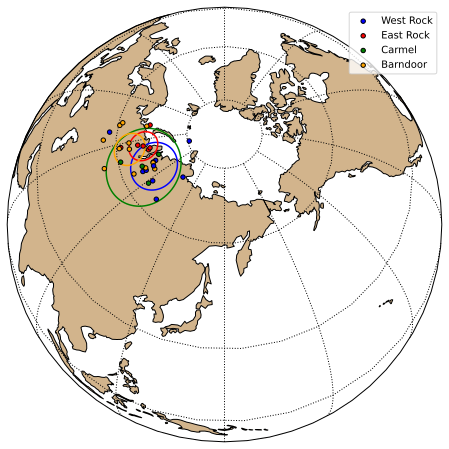

In [109]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Smith1985a_sites_WR_tilt_corrected['vgp_lon'].tolist(),Smith1985a_sites_WR_tilt_corrected['vgp_lat'].tolist(), color = 'blue', label = 'West Rock')
ipmag.plot_vgp(map_axis,Smith1985a_sites_ER_tilt_corrected['vgp_lon'].tolist(),Smith1985a_sites_ER_tilt_corrected['vgp_lat'].tolist(), color = 'red', label = 'East Rock')
ipmag.plot_vgp(map_axis,Smith1985a_sites_Carmel_tilt_corrected['vgp_lon'].tolist(),Smith1985a_sites_Carmel_tilt_corrected['vgp_lat'].tolist(), color = 'green', label = 'Carmel')
ipmag.plot_vgp(map_axis,Smith1985a_sites_Barndoor_tilt_corrected['vgp_lon'].tolist(),Smith1985a_sites_Barndoor_tilt_corrected['vgp_lat'].tolist(), color = 'orange', label = 'Barndoor')


ipmag.plot_pole(map_axis, Smith1985a_sites_WR_vgp_mean_tc['dec'], Smith1985a_sites_WR_vgp_mean_tc['inc'], 
                Smith1985a_sites_WR_vgp_mean_tc['alpha95'], color = 'blue')
ipmag.plot_pole(map_axis, Smith1985a_sites_ER_vgp_mean_tc['dec'], Smith1985a_sites_ER_vgp_mean_tc['inc'], 
                Smith1985a_sites_ER_vgp_mean_tc['alpha95'], color = 'red')
ipmag.plot_pole(map_axis, Smith1985a_sites_Carmel_vgp_mean_tc['dec'], Smith1985a_sites_Carmel_vgp_mean_tc['inc'], 
                Smith1985a_sites_Carmel_vgp_mean_tc['alpha95'], color = 'green')
ipmag.plot_pole(map_axis, Smith1985a_sites_Barndoor_vgp_mean_tc['dec'], Smith1985a_sites_Barndoor_vgp_mean_tc['inc'], 
                Smith1985a_sites_Barndoor_vgp_mean_tc['alpha95'], color = 'orange')

plt.legend()
plt.show()

Although Smith and Noltimier in the discussion say that the Barndoor pole (orange color) is distinguishable from other pole positions, here after tilt correction and the 15 degree a95 screening, the mean pole position is not very far from the otehr locations, it is even indistinguishable with the pole from East Rock. I am comfortable here to group all above data in one and make them the intrusive pole from the Hartford Basin. 

Note that Sutter and Smith (1979) published two Ar/Ar date for this Barndoor dike which are about 173 Ma and 168 Ma. 

## Rigotti (1976 thesis, 1978 publication using thesis data) Palisade diabase sills 

Inspired by interests in the secular variation and cooling effect on paleomagnetic directions of intrusive units over long period of time, Rigotti did this pilot research in sampling the Palisade sills in New Jersey. The sills is 1000 feet (300 meters) thick and was dated to be about 192 Ma according to Erickson and Kulp, 1961; Dallmeyer, 1975. Specifically, K-Ar ages reported by Dallmeyer (1975) show ages of 192 ± 9 for the upper chilled zone and 193 ± 9 Ma for the lower zone.  Outcropping along the Hudson River for about 50 miles, the sills intrudes the Newark Formation. Specifically, the uppermost Lockatung Formation and the basal lockatong Formation of the Newark Series. The sills are composed of tholeiitic diabase.

Standard paleomagnetic cores were collected from the sills and AF demagnetized up to 30 mT (a few up to 120 mT) and some were thermally demagnetized. Curie temperature of 550-580 degree C suggest dominant magnetic carrier of Fe-low Ti oxides. 

The structural correlation along paired with good resolution paleomagnetic data from Newark Formation is indication that the date of the sill might be younger than the 192 Ma. 

The appendix table included in this dissertation work is the sample level measurement data following AF demagnetization up to 30 mT. It is a large collection of data and only a mean pole position without concentration parameters are provided. lon = 74.5, lat = 97.6 

This mean pole position is very similar to those derived from the Newark basin, Hartford basin, and the Appalachians. 

If it turns out that re-compiling and analyzing these data will be of significant importance of refining the Monster Shift pole path, we will compile the sample files for these samples involved in the dissertation and make better use of these data. 

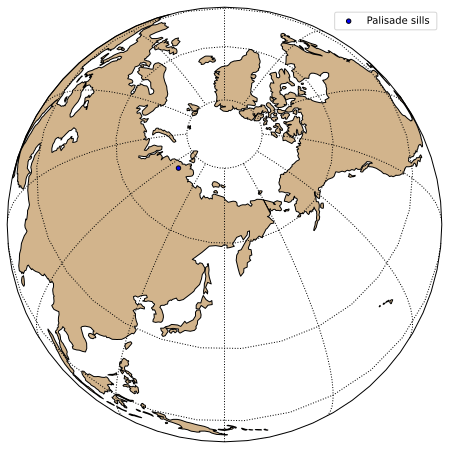

In [139]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis, 97.6, 74.5, color = 'blue', label = 'Palisade sills ')

plt.legend()
plt.show()

## Larochelle (1971) Anticosti dikes in Anticosti Island, Quebec

This is a paleomagnetism study of 2 dikes from Anticosti Island Quebec. The original paper is not available online or Berkeley library. However there is a data repo in the MagIC database, inclding only a mean direction from the 2 dikes (11 samples). According to the MagIC file, up to 25 mT AF cleaning was done, and certainly blanket demag with no least-square fit was performed. 

Because there are only two dikes studied in this work, there is not sufficient data for k or a95 statistical analyses on site level. However, in the MagIC file there is a dp and dm record included, which we can use to back out an a95 number, which may be used for defining a pole position, but statistically this a95 have little significance in representing the uncertainties for the paleomagnetic pole position of the time period these dikes were emplaced. 

The age range (172-195 Ma) is provided in the MagIC data file. It is a K-Ar age on the diabase dike.

Larochelle, A. (1971, January). NOTE ON PALEOMAGNETISM OF 2 DIABASE DYKES, ANTICOSTI ISLAND, QUEBEC. In PROCEEDINGS OF THE GEOLOGICAL ASSOCIATION OF CANADA (Vol. 23, No. FEB, pp. 73-+).

In [4]:
Larochelle1971a_site_mean = pd.read_csv('pmag_compiled/Larochelle1971a/locations.txt', sep = '\t', header = 1)
Larochelle1971a_site_mean

,age_high,age_low,age_unit,citations,conglomerate_test,contact_test,continent_ocean,country,description,dir_dec,...,pole_dm,pole_dp,pole_lat,pole_lon,pole_reversed_perc,region,result_name,result_type,reversal_test,rock_magnetic_test
0,195,172,Ma,This study,ND,ND,North America,Canada,AF cleaning 25mT.,9.5,...,1.5,1.1,75.7,84.7,0,Quebec,3229,i,ND,ND


In [16]:
a95_dp, a95_dm = calc_a95(56.6, 1.1, 1.5)


1.0499979245874655 1.036272895420234


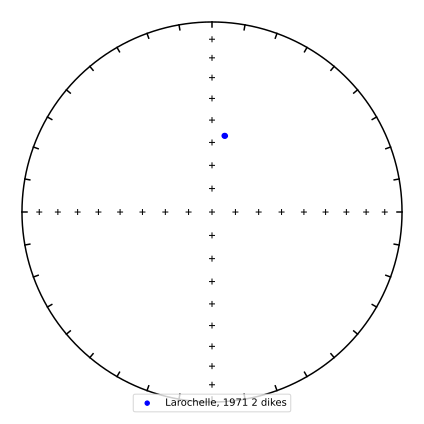

In [17]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di_mean(Larochelle1971a_site_mean['dir_dec'][0], Larochelle1971a_site_mean['dir_inc'][0], 1.04, color = 'blue', label = 'Larochelle, 1971 2 dikes')

plt.legend(loc = 8)
plt.show()

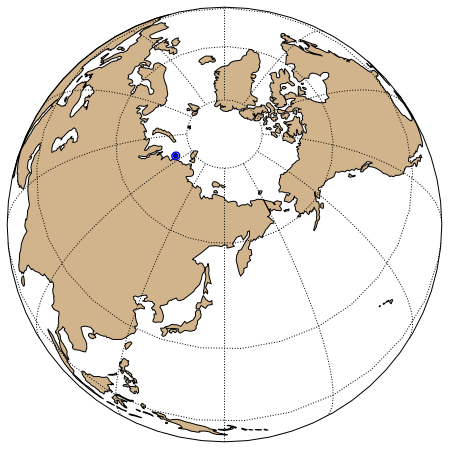

In [18]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_pole(map_axis,Larochelle1971a_site_mean['pole_lon'][0],Larochelle1971a_site_mean['pole_lat'][0], 1.04, color = 'blue')

plt.show()

In [19]:
pole_means.loc['Anticosti_2_dikes'] = pd.Series({'PoleName' : 'Anticosti dikes',
                                        'SLat' : 49.8,
                                        'SLon' : 296.8,
                                        'PLat' : Larochelle1971a_site_mean['pole_lon'][0],
                                        'PLon' : Larochelle1971a_site_mean['pole_lat'][0],
                                        'A95' : 1.04,
                                        'K' : kappa_from_two_sigma(1.04),
                                        'N' : Larochelle1971a_site_mean['dir_n_sites'],
                                        'PolarityZone' : 'Anticosti normal',
                                        'PmagRef' : 'Larochelle, 1971',
                                        'AgeNominal' : 183.0,
                                        'AgeLower' : 183.0-11.5,
                                        'AgeUpper' : 183.0+11.5,
                                        'AgeInfo' : 'not sure what dating method was used',
                                        'AgeRef' : 'Larochelle, 1971',
                                        'Gaussian_2sigma': 11.5,                                                   
                                        'GaussianOrUniform' : 'Gaussian',
                                        'Q' : 0,
                                        'color' : 'C0'})

## Prevot (1989) Newark Supergroup extrusive volcanics

This study focuses on the Newwar Supergroup volcanics from the Deerfield, Hartford, and Newark basins. A total of 15 sites were reported. They describe that sites from the Talcott and Hampden basalts yield indistinguishable directions. In contrast, sites collected from the intervening Holyoke basalt yield significantly different directions characterized by a much shallower inclination and more easterly declination. 

We can see in the first equal area plot below showing all data from that study, that some of the site directions are not coherent with the otehrs, which are dominantly to the north and down. The exceptional ones are having more north-easterly and shallower up or down directions. This may be attributed to the viscosity of the samples from the site. Although the details of that viscosity measurement need to be further investigated. 

Given that this study uses AF demagnetization up to 80 mT and performs principal component analyses yielding quite well grouped directions (reasonable a95). The site level directional data should be of quite good quality. 

No tilt correction mentioned. 

It is worth noting that the geochronology data on these basalt flows are indirect and are ambiguous. Prevot (1989) referred to available data from the intrusives instead of the extrusive in the Hartford and Newark area. The Ar/Ar ages range from ~187 ± 3 Ma to 202 ± 1 Ma. This correlation between the volcanics and the intrusives is based on the paleomagnetic pole position similarity derived from the igneous units. 

Prévot, M., & McWilliams, M. (1989). Paleomagnetic correlation of Newark Supergroup volcanics. Geology, 17(11), 1007-1010. doi: 10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2.

In [20]:
Prevot1989a_sites = pd.read_csv('pmag_compiled/Prevot1989a/Prevot1989a_sites.txt', sep = '\t', header = 1)
Prevot1989a_sites = ipmag.vgp_calc(Prevot1989a_sites,     tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
Prevot1989a_sites

,site,location,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_total_specimens,dir_tilt_correction,dir_alpha95,...,age,age_high,age_low,age_unit,citations,paleolatitude,vgp_lat,vgp_lon,vgp_lat_rev,vgp_lon_rev
0,D,Deerfield basin,10.8,-6.0,258,10,10,10,100,2.8,...,189,194,185,Ma,10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2,-3.008247,43.343324,92.539033,-43.343324,272.539033
1,H1A,Hartford basin,2.8,30.6,325,5,5,5,100,3.5,...,189,194,185,Ma,10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2,16.472905,64.453465,101.001835,-64.453465,281.001835
2,H1B,Hartford basin,358.3,33.6,275,8,8,8,100,3.0,...,189,194,185,Ma,10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2,18.376446,66.607416,111.254271,-66.607416,291.254271
3,H2A,Hartford basin,18.5,-3.3,269,9,9,9,100,2.8,...,189,194,185,Ma,10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2,-1.651370,42.975774,81.783588,-42.975774,261.783588
4,H2B,Hartford basin,12.3,-6.8,739,5,5,5,100,2.3,...,189,194,185,Ma,10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2,-3.412015,43.057669,90.405814,-43.057669,270.405814
5,H2C,Hartford basin,29.0,5.4,700,5,5,5,100,2.4,...,189,194,185,Ma,10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2,2.706009,42.982402,65.789110,-42.982402,245.789110
6,H3A,Hartford basin,6.0,29.6,165,8,8,8,100,3.9,...,189,194,185,Ma,10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2,15.856642,63.248622,94.410948,-63.248622,274.410948
7,H3B,Hartford basin,1.5,32.0,191,9,9,9,100,3.6,...,189,194,185,Ma,10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2,17.350615,65.211432,103.902518,-65.211432,283.902518
8,H3C,Hartford basin,4.8,30.4,741,10,10,10,100,1.6,...,189,194,185,Ma,10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2,16.348959,64.361940,96.537494,-64.361940,276.537494
9,W1A,Newark basin,4.0,23.8,102,4,4,4,100,6.9,...,189,194,185,Ma,10.1130/0091-7613(1989)017<1007:pconsv>2.3.co;2,12.436177,61.551394,97.381666,-61.551394,277.381666


No handles with labels found to put in legend.


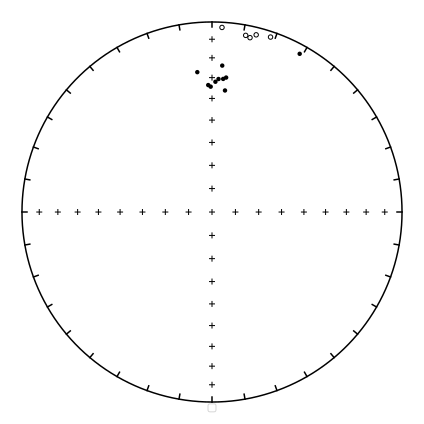

In [21]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Prevot1989a_sites['dir_dec'], Prevot1989a_sites['dir_inc'])

# ipmag.plot_di_mean(Larochelle1971a_site_mean['dir_dec'][0], Larochelle1971a_site_mean['dir_inc'][0], 1.04, color = 'blue', label = 'Larochelle, 1971 2 dikes')

plt.legend(loc = 8)
plt.show()

In [22]:
Prevot1989a_sites = Prevot1989a_sites[Prevot1989a_sites['dir_inc'] >= 6]

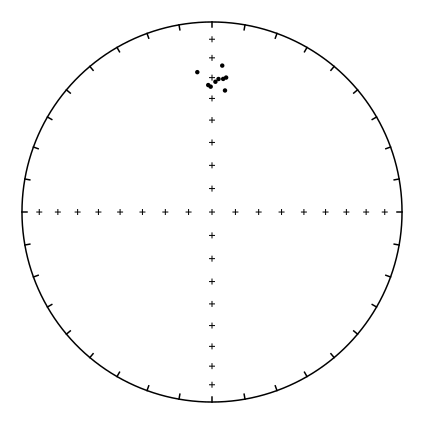

In [23]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Prevot1989a_sites['dir_dec'].tolist(), Prevot1989a_sites['dir_inc'].tolist())

# ipmag.plot_di_mean(Larochelle1971a_site_mean['dir_dec'][0], Larochelle1971a_site_mean['dir_inc'][0], 1.04, color = 'blue', label = 'Larochelle, 1971 2 dikes')

# plt.legend(loc = 8)
plt.show()

In [24]:
Prevot1989a_sites_vgp_mean = ipmag.fisher_mean(Prevot1989a_sites['vgp_lon'].tolist(),Prevot1989a_sites['vgp_lat'].tolist())
Prevot1989a_sites_vgp_mean

{'dec': 102.20583395348359,
 'inc': 65.27419283785504,
 'n': 9,
 'r': 8.975720143957863,
 'k': 329.4912451752735,
 'alpha95': 2.8405435570105917,
 'csd': 4.462344331913141}

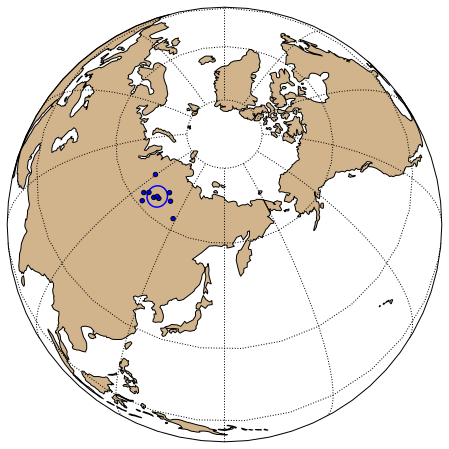

In [25]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,Prevot1989a_sites['vgp_lon'].tolist(),Prevot1989a_sites['vgp_lat'].tolist(), color = 'blue')
ipmag.plot_pole(map_axis, Prevot1989a_sites_vgp_mean['dec'], Prevot1989a_sites_vgp_mean['inc'], Prevot1989a_sites_vgp_mean['alpha95'], color = 'blue')
plt.show()

In [26]:
pole_means.loc['Newark_volcanics'] = pd.Series({'PoleName' : 'Newark Supergroup Volcanics',
                                        'SLat' : 42.614,
                                        'SLon' : 360-72.551,
                                        'PLat' : Prevot1989a_sites_vgp_mean['inc'],
                                        'PLon' : Prevot1989a_sites_vgp_mean['dec'],
                                        'A95' : Prevot1989a_sites_vgp_mean['alpha95'],
                                        'K' : Prevot1989a_sites_vgp_mean['k'],
                                        'N' : Prevot1989a_sites_vgp_mean['n'],
                                        'PolarityZone' : 'Newark normal',
                                        'PmagRef' : 'Prevot & McWilliams, 1989',
                                        'AgeNominal' : 189,
                                        'AgeLower' : 194,
                                        'AgeUpper' : 185,
                                        'AgeInfo' : 'a broad estimate based on several studies',
                                        'AgeRef' : 'de Boer, 1968; Armstrong and Besancon, 1970; Sutter and Smith, 1979; Seidemann et al., 1984',
                                        'Gaussian_2sigma': 5,                                                   
                                        'GaussianOrUniform' : 'Gaussian',
                                        'Q' : 0,
                                        'color' : 'C0'})

## McIntosh (1985) basalt flows from Newark Basin

AF demagnetizations were performed on the Watchung basalts up to 30 mT. 

In [64]:
McIntosh1985a_sites = pd.read_csv('pmag_compiled/McIntosh1985a/McIntosh1985a_sites.txt', sep = '\t', header = 1)
McIntosh1985a_sites = McIntosh1985a_sites[McIntosh1985a_sites['dir_alpha95'] <= 15]
McIntosh1985a_sites = ipmag.vgp_calc(McIntosh1985a_sites, tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')
McIntosh1985a_sites['location'].unique()

array(['Orange Mountain', 'Preakness', 'Hook Mountain'], dtype=object)

In [65]:
McIntosh1985a_Orange_Mountain = McIntosh1985a_sites[McIntosh1985a_sites['location'] == 'Orange Mountain']
McIntosh1985a_Preakness = McIntosh1985a_sites[McIntosh1985a_sites['location'] == 'Preakness']
McIntosh1985a_Hook_Mountain = McIntosh1985a_sites[McIntosh1985a_sites['location'] == 'Hook Mountain']

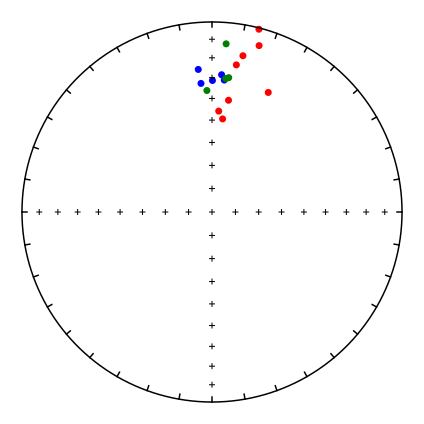

In [68]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(McIntosh1985a_Orange_Mountain['dir_dec'].tolist(), McIntosh1985a_Orange_Mountain['dir_inc'].tolist(), color = 'blue', markersize = 50)
ipmag.plot_di(McIntosh1985a_Preakness['dir_dec'].tolist(), McIntosh1985a_Preakness['dir_inc'].tolist(), color = 'red', markersize = 50)
ipmag.plot_di(McIntosh1985a_Hook_Mountain['dir_dec'].tolist(), McIntosh1985a_Hook_Mountain['dir_inc'].tolist(), color = 'green', markersize = 50)

# ipmag.plot_di_mean(Larochelle1971a_site_mean['dir_dec'][0], Larochelle1971a_site_mean['dir_inc'][0], 1.04, color = 'blue', label = 'Larochelle, 1971 2 dikes')

# plt.legend(loc = 8)
plt.show()

In [69]:
McIntosh1985a_Orange_Mountain_vgp_mean = ipmag.fisher_mean(McIntosh1985a_Orange_Mountain['vgp_lon'].tolist(),McIntosh1985a_Orange_Mountain['vgp_lat'].tolist())
McIntosh1985a_Preakness_vgp_mean = ipmag.fisher_mean(McIntosh1985a_Preakness['vgp_lon'].tolist(),McIntosh1985a_Preakness['vgp_lat'].tolist())
McIntosh1985a_Hook_Mountain_vgp_mean = ipmag.fisher_mean(McIntosh1985a_Hook_Mountain['vgp_lon'].tolist(),McIntosh1985a_Hook_Mountain['vgp_lat'].tolist())

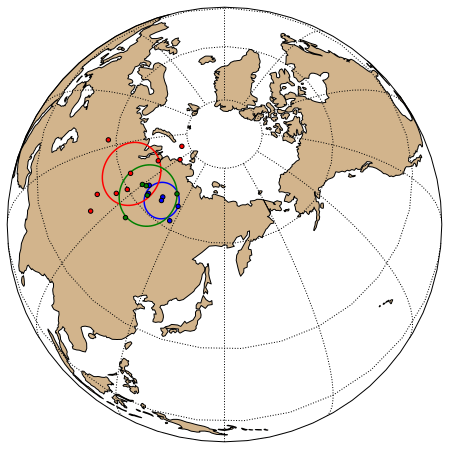

In [70]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_vgp(map_axis,McIntosh1985a_Orange_Mountain['vgp_lon'].tolist(),McIntosh1985a_Orange_Mountain['vgp_lat'].tolist(), color = 'blue')
ipmag.plot_vgp(map_axis,McIntosh1985a_Preakness['vgp_lon'].tolist(),McIntosh1985a_Preakness['vgp_lat'].tolist(), color = 'red')
ipmag.plot_vgp(map_axis,McIntosh1985a_Hook_Mountain['vgp_lon'].tolist(),McIntosh1985a_Hook_Mountain['vgp_lat'].tolist(), color = 'green')

ipmag.plot_pole(map_axis, McIntosh1985a_Orange_Mountain_vgp_mean['dec'], McIntosh1985a_Orange_Mountain_vgp_mean['inc'], 
                McIntosh1985a_Orange_Mountain_vgp_mean['alpha95'], color = 'blue')
ipmag.plot_pole(map_axis, McIntosh1985a_Preakness_vgp_mean['dec'], McIntosh1985a_Preakness_vgp_mean['inc'], 
                McIntosh1985a_Preakness_vgp_mean['alpha95'], color = 'red')
ipmag.plot_pole(map_axis, McIntosh1985a_Hook_Mountain_vgp_mean['dec'], McIntosh1985a_Hook_Mountain_vgp_mean['inc'], 
                McIntosh1985a_Hook_Mountain_vgp_mean['alpha95'], color = 'green')

plt.show()

In [73]:
# add to pole_means dataframe

## Torsvik (2012) MS pole compilation

The method is a moving average using a 20 Myr window. 

In [27]:
# the format will be of lat, lon, A95

Torsvik_2012_160_Ma = [70.1, 137.5, 4.9]

## Kent (2010) compilation work on NA APWP from 250 Ma to 40 Ma



In [218]:
Kent2010a_poles = pd.read_csv('pmag_compiled/Kent2010a/Kent2015a_compiled_poles.csv')
Kent2010a_poles = Kent2010a_poles[Kent2010a_poles['A95'] < 10]
Kent2010a_poles_200_140 = Kent2010a_poles[(Kent2010a_poles['Age'] > 140) & (Kent2010a_poles['Age'] < 200) ]
Kent2010a_poles_200_plus = Kent2010a_poles[Kent2010a_poles['Age'] > 200]
Kent2010a_poles_140_minus =  Kent2010a_poles[Kent2010a_poles['Age'] < 140]

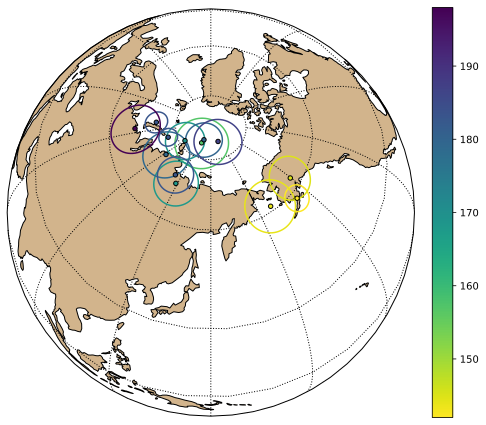

In [219]:
# plotting poles from 200 ma to 140 Ma
map_axis = ipmag.make_orthographic_map(150, 65)
cNorm  = matplotlib.colors.Normalize(vmin=min(Kent2010a_poles_200_140['Age']), vmax=max(Kent2010a_poles_200_140['Age']))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

for i in range(len(Kent2010a_poles_200_140['Item'])):
    rgba = scalarMap.to_rgba(Kent2010a_poles_200_140['Age'].tolist()[i])
    hex_color = colors.rgb2hex(rgba)
    ipmag.plot_pole(map_axis, Kent2010a_poles_200_140['PLon'].tolist()[i], Kent2010a_poles_200_140['PLat'].tolist()[i], Kent2010a_poles_200_140['A95'].tolist()[i], 
                    color = hex_color)

scalarMap.set_array(np.linspace(min(Kent2010a_poles_200_140['Age']), max(Kent2010a_poles_200_140['Age'])))
plt.colorbar(scalarMap,orientation='vertical',fraction=0.046, pad=0.04)
plt.show()

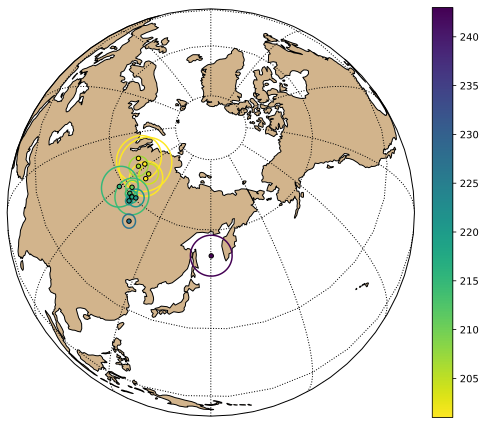

In [220]:
# plotting poles from 200 ma on 
map_axis = ipmag.make_orthographic_map(150, 65)
cNorm  = matplotlib.colors.Normalize(vmin=min(Kent2010a_poles_200_plus['Age']), vmax=max(Kent2010a_poles_200_plus['Age']))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

for i in range(len(Kent2010a_poles_200_plus['Item'])):
    rgba = scalarMap.to_rgba(Kent2010a_poles_200_plus['Age'].tolist()[i])
    hex_color = colors.rgb2hex(rgba)
    ipmag.plot_pole(map_axis, Kent2010a_poles_200_plus['PLon'].tolist()[i], Kent2010a_poles_200_plus['PLat'].tolist()[i], Kent2010a_poles_200_plus['A95'].tolist()[i], 
                    color = hex_color)

scalarMap.set_array(np.linspace(min(Kent2010a_poles_200_plus['Age']), max(Kent2010a_poles_200_plus['Age'])))
plt.colorbar(scalarMap,orientation='vertical',fraction=0.046, pad=0.04)
plt.show()

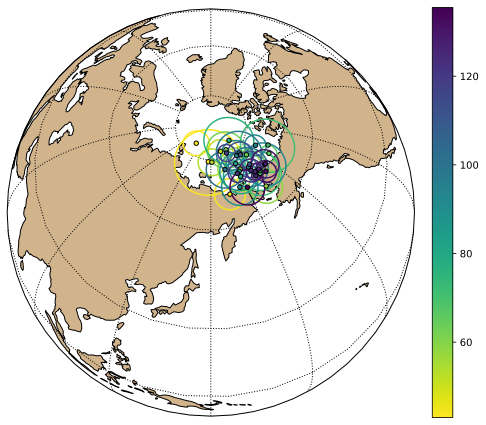

In [221]:
# plotting poles from 140 ma to 40 ma 
map_axis = ipmag.make_orthographic_map(150, 65)
cNorm  = matplotlib.colors.Normalize(vmin=min(Kent2010a_poles_140_minus['Age']), vmax=max(Kent2010a_poles_140_minus['Age']))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

for i in range(len(Kent2010a_poles_140_minus['Item'])):
    rgba = scalarMap.to_rgba(Kent2010a_poles_140_minus['Age'].tolist()[i])
    hex_color = colors.rgb2hex(rgba)
    ipmag.plot_pole(map_axis, Kent2010a_poles_140_minus['PLon'].tolist()[i], Kent2010a_poles_140_minus['PLat'].tolist()[i], Kent2010a_poles_140_minus['A95'].tolist()[i], 
                    color = hex_color)

scalarMap.set_array(np.linspace(min(Kent2010a_poles_140_minus['Age']), max(Kent2010a_poles_140_minus['Age'])))
plt.colorbar(scalarMap,orientation='vertical',fraction=0.046, pad=0.04)
plt.show()

In [222]:
Kent2010a_poles_200_plus.to_csv('pmag_compiled/compiled_Kent_2010_2015_poles_200_plus.csv')

## Van Fossen and kent (1990) Plutons and Moat Volcanics

Both the plutons and Moat volcanics have dates around 169 Ma, and they both display a pole position that is indistinguishable with the spin axis. The volcanics show normal and reversed polarities and aid in the argument that the spin-axis pole is not a present day field overprint.

They sampled Conway granite from White Mountain batholith; a diorite plug and Albany quartz syenite from Mount Kearsag; in Belknap Mountains they sampled quartz syenite and quartz diorite from ring dikes, 
They sampled extrusive effusive Moat Volcanics pyroclastic quartz trachyte and comendite flows,ashflow tuffs and breccia.


The Conway granite is younger than the syenite from around Kearsag; the moat volcanics is reported to be intruded by the Conway granite which has been dated to be 168 ± 3 Ma, this is interpreted to be the minimum age of the Moat Volcanics. **A recent 54th Northeastern section GSA meeting abstract https://gsa.confex.com/gsa/2019NE/webprogram/Paper327960.html suggest that the age of the Moat volcanics is much older (~10 Myr) than 168 Ma. But no detailed result is presented on the online abstract.**


Van Fossen, M. C., & Kent, D. V. (1990). High‐latitude paleomagnetic poles from Middle Jurassic plutons and moat volcanics in New England and the controversy regarding Jurassic apparent polar wander for North America. Journal of Geophysical Research: Solid Earth, 95(B11), 17503-17516. doi:10.1029/JB095iB11p17503.

In [41]:
VanFossen1990a_sites = pd.read_csv('pmag_compiled/VanFossen1990a_sites.txt', sep = '\t', header = 1)
VanFossen1990a_sites

,age_high,age_low,age_unit,citations,conglomerate_test,contact_test,country,description,dir_alpha95,dir_dec,...,dir_tilt_correction,fold_test,geologic_classes,geological_province_sections,lithologies,location,lon_e,method_codes,result_type,pole_comp_name
0,172,166,Ma,This study,ND,ND,U.S.A.,Minimum age from intruding Conway Granite (168...,5.0,183.4,...,100,F-,Extrusive,Moat Volcanics,Breccia : Tuff:Trachyte,Moat Volcanics,288.9,DE-DI:LT-AF-Z:LT-T-Z:LP-DC4,i,C
1,172,166,Ma,This study,ND,ND,U.S.A.,Minimum age from intruding Conway Granite (168...,16.6,187.0,...,0,F-,Extrusive,Moat Volcanics,Breccia : Tuff:Trachyte,Moat Volcanics,288.9,DE-DI:LT-AF-Z:LT-T-Z:LP-DC4,i,C
2,172,166,Ma,This study,ND,ND,U.S.A.,Minimum age from intruding Conway Granite (168...,5.0,183.4,...,0,F-,Extrusive,Moat Volcanics,Breccia : Tuff:Trachyte,Moat Volcanics,288.9,DE-DI:LT-AF-Z:LT-T-Z:LP-DC4,i,C
3,172,166,Ma,This study,ND,ND,U.S.A.,Minimum age from intruding Conway Granite (168...,7.0,2.1,...,0,F-,Extrusive,Moat Volcanics,Breccia : Tuff:Trachyte,Moat Volcanics,288.9,DE-DI:LT-AF-Z:LT-T-Z:LP-DC4,i,C
4,172,166,Ma,This study,ND,ND,U.S.A.,Minimum age from intruding Conway Granite (168...,7.4,184.3,...,0,F-,Extrusive,Moat Volcanics,Breccia : Tuff:Trachyte,Moat Volcanics,288.9,DE-DI:LT-AF-Z:LT-T-Z:LP-DC4,i,C
5,177,161,Ma,This study,ND,ND,U.S.A.,"AF to 100mT, thermal to 650C, univectorial.",8.3,1.5,...,0,ND,Intrusive,White Mountains Plutons,Diorite: Syenite :Granite,White Mountains Plutons,288.5,DE-VGP:LT-AF-Z:LT-T-Z:LP-DC4,i,NaN


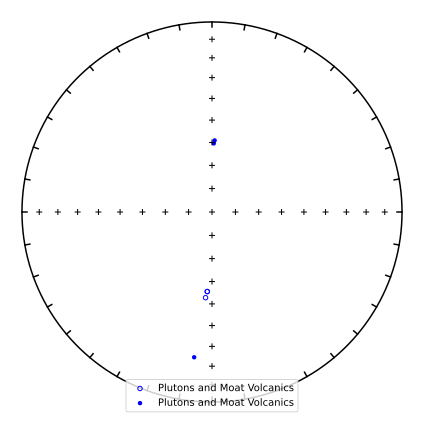

In [42]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(VanFossen1990a_sites['dir_dec'].tolist(), VanFossen1990a_sites['dir_inc'].tolist(), color = 'blue', label = 'Plutons and Moat Volcanics')

# ipmag.plot_di_mean(Kent2015_Peddie_mean['dec'], Kent2015_Peddie_mean['inc'], Kent2015_Peddie_mean['alpha95'], color = 'blue', label = 'Peddie')

plt.legend(loc = 8)
plt.show()

**Above is what is presented on MagIC database**

However, this publication is an early study and appears to be messy with today's judgement. Also often it is being taken in many recent compilation studies related to this APW takes the word for it and just uses the Cr component from the Moat volcanics, excluding all other directions from the plutons or other components from the volcanics. It is worth noting that Torsvik 2012 compilation too, just uses the Cr component. Here we will just use that pole.

What is also ambiguous is the age constraint for this unit. The authors of this paper present aan age without uncertainty quoting a personal communication with J. Creasy. However, to properly deploy a model setup for Bayesian analyses, we need some age uncertainty for this unit. There exsit an age for the plutonic rocks in the area of 169 ± 8 Ma, also a K-Ar age on biotite in pluton with age 168 ± 3 Ma (Foland et al., 1971). However, these uncertainties may not represent the age of the entire activity of plutonic activity during thsi period, as referred in this paper there are intrusive units of ages from 175 Ma to 160 Ma.

However, for the Moat Volcanics, we suggest that either a conservative age estimate of 169 ± 8 Ma or 168 ± 3 Ma should be assinged for the Moat volcanics.

In [43]:
pole_means.loc['Moat_volcanics'] = pd.Series({'PoleName' : 'Moat Volcanics',
                                        'SLat' : 47.443,
                                        'SLon' : 44.08,
                                        'PLat' : 78.7,
                                        'PLon' : 90.3,
                                        'A95' : 7.4,
                                        'K' : round(140*140/7.4/7.4/9, 1),
                                        'N' : int(9),
                                        'PolarityZone' : 'Moat early reversed',
                                        'PmagRef' : 'Van-Fossen & Kent, 1990',
                                        'AgeNominal' : 169,
                                        'AgeLower' : 169-8,
                                        'AgeUpper' : 169+8,
                                        'AgeInfo' : 'Rb-Sr age fro mplutonic rocks associated with the Moat Volcanics',
                                        'AgeRef' : 'VanFossen & Kent, 1990',
                                        'Gaussian_2sigma': 8, 
                                        'GaussianOrUniform' : 'Gaussian',
                                        'Q' : 0,
                                        'color' : 'C0'})

## Kent(2015) kimberlites in Triple B and Peddie

This study sampled kimberlites, a type of ultramafic rock sourced from great deapth in mantle. The significance of these samples is that the kimberlites have been dated to be around 150 Ma, which is middle between the stand still pole near 160 Ma and the 140 Ma pole after the Monster Shift. It can provide suppport for a constant, rapid shift rate.

Geochronology data acquired using U-Pb dating on perovskite, a Ca-Ti oxide mineral. 

The idea of the origin of the magnetization in this kimberlite is proposed to be not of TRM, but of ChRM by hydrothermal fluids circulating after the emplacement of kimberlite from great depth and precipitating out magnetite. 

Site Peddie and Triple B:
Paleomagnetism data acquired using the kimberlite resulted in tightly clustered directions, with both polarities from samples of different localities. Curie temperature of 575 indicate magnetite/titanomagnetitte to be dominant carriers. However, the very small A95 -- super tight cluster of ChRM directions makes it suspicious that the secular variation is properly averaged. The authors argue that the formation of magnetite is likely not at great-depth where kimberlite forms but at shallower depth during the late stage crystallization or thermochemical interaction between kimberlite and hydrothermal fluids. With these proposed schemes, it is likely that the duration of magnetite formation is long enough for secular variation averaging. 

The age constraint on this unit is 206Pb/238U date on perovskite from the groundmass of the kimberlite. 

Kent, D. V., B. A. Kjarsgaard, J. S. Gee,
G. Muttoni, and L. M. Heaman (2015), Tracking the Late Jurassic apparent (or true) polar shift in U-Pb-dated kimberlites from cratonic North America (Superior Province of Canada), Geochem. Geophys. Geosyst., 16, 983– 994, doi:10.1002/2015GC005734.

In [28]:
# importing sample level data from Kent 2015
Kent2015_samples = pd.read_csv('pmag_compiled/Kent2015a_samples.txt', sep = '\t', header = 1)
Kent2015_samples['sample'].unique()

array(['JBBB01', 'JBBB02', 'JBBB03', 'JBBB04', 'JBBB05', 'JBBB06',
       'JBBB07', 'JBBB08', 'JBBB09', 'JBBB10', 'JBBB11', 'JBBB12',
       'JBBB13', 'JBBB14', 'JBBB15', 'JPED01', 'JPED02', 'JPED03a',
       'JPED03b', 'JPED04', 'JPED05', 'JPED06', 'JPED07', 'JPED08',
       'JPED09', 'JPED10', 'JPED11', 'JPED12', 'JPED13', 'JPED14',
       'JPED15', 'JPED16', 'JPED17', 'JPED18', 'JPED19', 'JPED31',
       'JPED32', 'JPED33', 'JPED34'], dtype=object)

In [29]:
Kent2015_samples = Kent2015_samples.drop(Kent2015_samples[Kent2015_samples['sample'] == 'JPED13'].index)
Kent2015_samples = ipmag.vgp_calc(Kent2015_samples, site_lon='lon', tilt_correction='no', site_lat='lat', dec_is = 'dir_dec', inc_is = 'dir_inc')

Kent2015_tripleB_samples = Kent2015_samples[Kent2015_samples['location'] == 'Triple B']
Kent2015_Peddie_samples = Kent2015_samples[Kent2015_samples['location'] == 'Peddie']
Kent2015_Nipissing_samples = Kent2015_samples[Kent2015_samples['location'] == 'Nipissing']

In [30]:
Kent2015_tripleB_mean = ipmag.fisher_mean(Kent2015_tripleB_samples['dir_dec'].tolist(), Kent2015_tripleB_samples['dir_inc'].tolist())
Kent2015_Peddie_mean = ipmag.fisher_mean(Kent2015_Peddie_samples['dir_dec'].tolist(), Kent2015_Peddie_samples['dir_inc'].tolist())
Kent2015_Nipissing_mean = ipmag.fisher_mean(Kent2015_Nipissing_samples['dir_dec'].tolist(), Kent2015_Nipissing_samples['dir_inc'].tolist())

In [31]:
print(Kent2015_tripleB_mean)
print(Kent2015_Peddie_mean)
print(Kent2015_Nipissing_mean)

{'dec': 162.2541558411837, 'inc': -65.40210462215336, 'n': 15, 'r': 14.913542605863027, 'k': 161.92946988224077, 'alpha95': 3.0139264176590097, 'csd': 6.365346825545106}
{'dec': 336.94411942483396, 'inc': 61.889878261211024, 'n': 19, 'r': 18.895316256709137, 'k': 171.94646880353815, 'alpha95': 2.5666824849756775, 'csd': 6.1771534244763275}
{'dec': 359.584287086439, 'inc': -55.13952128427369, 'n': 4, 'r': 3.9874134579401144, 'k': 238.34981726722646, 'alpha95': 5.963477304975023, 'csd': 5.24659579965618}


**Note the calculation for the triple B kimberlite pole shown above**

It is clear that the cited calculation results in the paper of Kent 2015 is wrong. They mistakened the k value, 161.9 for the mean declination for this site. The actual mean value is close, but nevertheless is different. It should be 162.3 for dec.

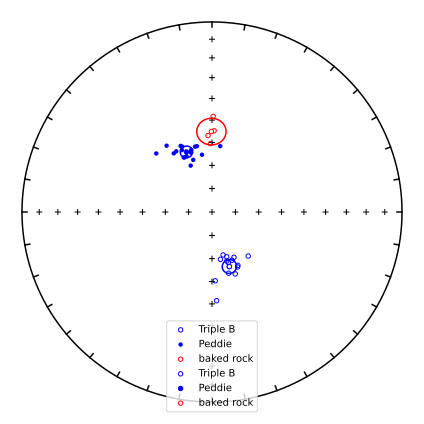

In [32]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(Kent2015_tripleB_samples['dir_dec'].tolist(), Kent2015_tripleB_samples['dir_inc'].tolist(), color = 'blue', label = 'Triple B')
ipmag.plot_di(Kent2015_Peddie_samples['dir_dec'].tolist(), Kent2015_Peddie_samples['dir_inc'].tolist(), color = 'blue', label = 'Peddie')
ipmag.plot_di(Kent2015_Nipissing_samples['dir_dec'].tolist(), Kent2015_Nipissing_samples['dir_inc'].tolist(), color = 'red', label = 'baked rock')

ipmag.plot_di_mean(Kent2015_tripleB_mean['dec'], Kent2015_tripleB_mean['inc'], Kent2015_tripleB_mean['alpha95'], color = 'blue', label = 'Triple B')
ipmag.plot_di_mean(Kent2015_Peddie_mean['dec'], Kent2015_Peddie_mean['inc'], Kent2015_Peddie_mean['alpha95'], color = 'blue', label = 'Peddie')
ipmag.plot_di_mean(Kent2015_Nipissing_mean['dec'], Kent2015_Nipissing_mean['inc'], Kent2015_Nipissing_mean['alpha95'], color = 'red', label = 'baked rock')

plt.legend(loc = 8)
plt.show()

### Reversal test between triple B and peddie kimberlites

In [33]:
Kent2015_tripleB_peddie = pd.concat([Kent2015_tripleB_samples, Kent2015_Peddie_samples])

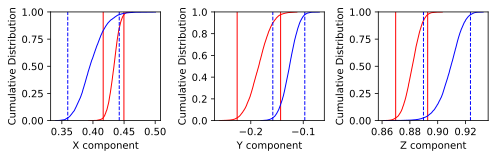

In [34]:
ipmag.reversal_test_bootstrap(Kent2015_tripleB_peddie['dir_dec'].tolist(), Kent2015_tripleB_peddie['dir_inc'].tolist())

In [35]:
ipmag.reversal_test_MM1990(Kent2015_tripleB_peddie['dir_dec'].tolist(), Kent2015_tripleB_peddie['dir_inc'].tolist())

Results of Watson V test: 

Watson's V:           7.5
Critical value of V:  6.1
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 4.2
Critical angle for M&M1990:   3.8



**They barely passed the reversal test!**

However, one could attribute this issue to the fact that both polarites are so tightly constrained, the A95 ellipses are too small.

In [36]:
Kent2015_tripleB_VGP_mean = ipmag.fisher_mean(Kent2015_tripleB_samples['vgp_lon_rev'].tolist(), Kent2015_tripleB_samples['vgp_lat_rev'].tolist())
Kent2015_Peddie_VGP_mean = ipmag.fisher_mean(Kent2015_Peddie_samples['vgp_lon'].tolist(), Kent2015_Peddie_samples['vgp_lat'].tolist())

In [37]:
print(Kent2015_tripleB_VGP_mean)
print(Kent2015_Peddie_VGP_mean)

{'dec': 198.86072807078588, 'inc': 77.87241595817281, 'n': 15, 'r': 14.83741041781541, 'k': 86.10637786193183, 'alpha95': 4.144134900055902, 'csd': 8.72905758582506}
{'dec': 184.09004576198237, 'inc': 73.47453918272288, 'n': 19, 'r': 18.785047132895986, 'k': 83.73928779135551, 'alpha95': 3.689043605222943, 'csd': 8.85157161522252}


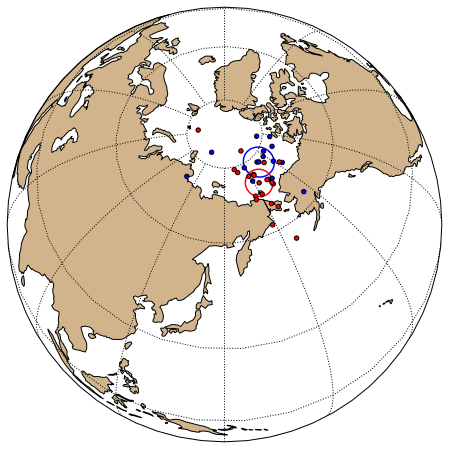

In [38]:
map_axis = ipmag.make_orthographic_map(150, 65)
ipmag.plot_vgp(map_axis, Kent2015_tripleB_samples['vgp_lon_rev'].tolist(), Kent2015_tripleB_samples['vgp_lat_rev'].tolist(), 
               color = 'blue', label = 'Triple B')
ipmag.plot_vgp(map_axis, Kent2015_Peddie_samples['vgp_lon'].tolist(), Kent2015_Peddie_samples['vgp_lat'].tolist(), 
               color = 'red', label = 'Peddie')

ipmag.plot_pole(map_axis, Kent2015_tripleB_VGP_mean['dec'], Kent2015_tripleB_VGP_mean['inc'], Kent2015_tripleB_VGP_mean['alpha95'], color = 'blue')
ipmag.plot_pole(map_axis, Kent2015_Peddie_VGP_mean['dec'], Kent2015_Peddie_VGP_mean['inc'], Kent2015_Peddie_VGP_mean['alpha95'], color = 'red')

plt.show()

In [39]:
pole_means.loc['Triple_B_kimberlite'] = pd.Series({'PoleName' : 'Triple B kimberlites',
                                        'SLat' : 47.454,
                                        'SLon' : 360-79.762,
                                        'PLat' : round(Kent2015_tripleB_VGP_mean['inc'],1),
                                        'PLon' : round(Kent2015_tripleB_VGP_mean['dec'],1),
                                        'A95' : round(Kent2015_tripleB_VGP_mean['alpha95'],1),
                                        'K' : round(Kent2015_tripleB_VGP_mean['k'],1),
                                        'N' : int(Kent2015_tripleB_VGP_mean['n']),
                                        'PolarityZone' : 'Triple B reversed',
                                        'PmagRef' : 'Kent et al., 2015',
                                        'AgeNominal' : 157.5,
                                        'AgeLower' : 157.5-1.2,
                                        'AgeUpper' : 157.5+1.2,
                                        'AgeInfo' : 'U-Pb date on perovskite from kimberlite yielding 157.5 $\pm$ 1.2 Ma)',
                                        'AgeRef' : 'Kent et al., 2015',
                                        'Gaussian_2sigma': 1.2,                                                   
                                        'GaussianOrUniform' : 'Gaussian',
                                        'Q' : 0,
                                        'color' : 'C2'})

In [40]:
pole_means.loc['Peddie_kimberlite'] = pd.Series({'PoleName' : 'Peddie kimberlites',
                                        'SLat' : 47.443,
                                        'SLon' : 360-79.682,
                                        'PLat' : round(Kent2015_Peddie_VGP_mean['inc'],1),
                                        'PLon' : round(Kent2015_Peddie_VGP_mean['dec'],1),
                                        'A95' : round(Kent2015_Peddie_VGP_mean['alpha95'],1),
                                        'K' : round(Kent2015_Peddie_VGP_mean['k'],1),
                                        'N' : int(Kent2015_Peddie_VGP_mean['n']),
                                        'PolarityZone' : 'Peddie normal',
                                        'PmagRef' : 'Kent et al., 2015',
                                        'AgeNominal' : 154.9,
                                        'AgeLower' : 154.9-1.1,
                                        'AgeUpper' : 154.9+1.1,
                                        'AgeInfo' : 'U-Pb date on perovskite from kimberlite yielding 154.9 $\pm$ 1.1 Ma)',
                                        'AgeRef' : 'Kent et al., 2015',
                                        'Gaussian_2sigma': 1.1, 
                                        'GaussianOrUniform' : 'Gaussian',
                                        'Q' : 0,
                                        'color' : 'C2'})

In [223]:
Kent2010a_poles_200_140.loc['54'] = pd.Series({'Item' : 70,
                                        'PLat' : round(Kent2015_tripleB_VGP_mean['inc'],1),
                                        'PLon' : round(Kent2015_tripleB_VGP_mean['dec'],1),
                                        'A95' : round(Kent2015_tripleB_VGP_mean['alpha95'],1), 
                                        'Age': 157.5, 
                                        'Continent': 'NAM', 
                                        'Pole ID': 'TB'})

In [224]:
Kent2010a_poles_200_140.loc['55'] = pd.Series({'Item' : 71,
                                        'PLat' : round(Kent2015_Peddie_VGP_mean['inc'],1),
                                        'PLon' : round(Kent2015_Peddie_VGP_mean['dec'],1),
                                        'A95' : round(Kent2015_Peddie_VGP_mean['alpha95'],1), 
                                        'Age': 154.9, 
                                        'Continent': 'NAM', 
                                        'Pole ID': 'Peddie'})

In [225]:
Kent2010a_poles_200_140.sort_values(by = 'Age', ascending = True)
Kent2010a_poles_200_140.to_csv('pmag_compiled/compiled_Kent_2010_2015_poles.csv')

## VanFossen (1993) 146 Ma Ithaca kimberlite dikes from Central New York

This study has samples from 143 Ma serpentinized kimberlite dikes in central New York. Featuring high-unblocing temperature, high coercivity, and passes reversal and baked contact test. 

These dikes are centimeter up to 2 m wide dikes in Ithaca, New York. unblocking temperature around 500-575 degree C indicating Fe-Ti as dominant remanent carrier. low MDF around 20-30 mT. they record tight NW and down direction with one exception of SE and up.

The freshest, xenolith-free dikes have age of 142 ± 4 Ma (Basu et al., 1984), although others have used other methods to date these units and yielded similar results. 


In [44]:
VanFossen1993a_sites = pd.read_csv('pmag_compiled/VanFossen1993a_sites.txt', sep = '\t', header = 1)
VanFossen1993a_sites = ipmag.vgp_calc(VanFossen1993a_sites, tilt_correction='no',
                                      site_lon='lon', site_lat='lat', dec_is='dir_dec', inc_is='dir_inc')

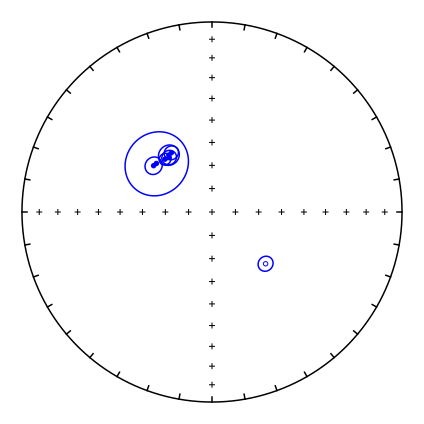

In [45]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(len(VanFossen1993a_sites['dir_dec'].tolist())):
    
    ipmag.plot_di_mean(VanFossen1993a_sites['dir_dec'][i], VanFossen1993a_sites['dir_inc'][i], VanFossen1993a_sites['dir_alpha95'][i], color = 'blue')

# ipmag.plot_di_mean(Kent2015_Peddie_mean['dec'], Kent2015_Peddie_mean['inc'], Kent2015_Peddie_mean['alpha95'], color = 'blue', label = 'Peddie')

# plt.legend(loc = 8)
plt.show()

In [46]:
Kent2015_tripleB_VGP_mean = ipmag.fisher_mean(Kent2015_tripleB_samples['vgp_lon_rev'].tolist(), Kent2015_tripleB_samples['vgp_lat_rev'].tolist())
Kent2015_Peddie_VGP_mean = ipmag.fisher_mean(Kent2015_Peddie_samples['vgp_lon'].tolist(), Kent2015_Peddie_samples['vgp_lat'].tolist())

In [47]:
VanFossen1993_vgp_lon = list()
VanFossen1993_vgp_lat = list()

VanFossen1993_vgp_lon.extend(VanFossen1993a_sites['vgp_lon_rev'].tolist()[:1])
VanFossen1993_vgp_lon.extend(VanFossen1993a_sites['vgp_lon'].tolist()[1:])
VanFossen1993_vgp_lat.extend(VanFossen1993a_sites['vgp_lat_rev'].tolist()[:1])
VanFossen1993_vgp_lat.extend(VanFossen1993a_sites['vgp_lat'].tolist()[1:])

VanFossen1993_vgp_mean = ipmag.fisher_mean(VanFossen1993_vgp_lon, VanFossen1993_vgp_lat)
VanFossen1993_vgp_mean

{'dec': 203.12175123870134,
 'inc': 58.08840826766953,
 'n': 7,
 'r': 6.976641639192904,
 'k': 256.8673396883749,
 'alpha95': 3.7735526027448736,
 'csd': 5.053945739969878}

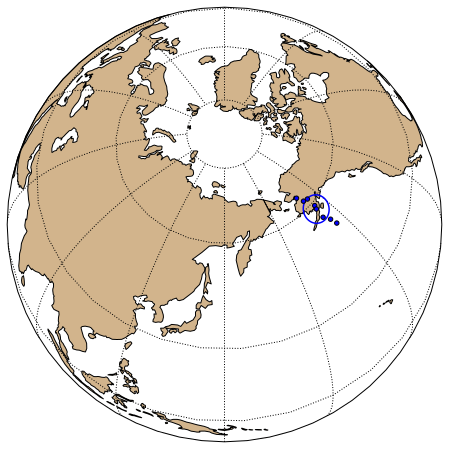

In [48]:
map_axis = ipmag.make_orthographic_map(150, 65)
ipmag.plot_vgp(map_axis, VanFossen1993_vgp_lon, VanFossen1993_vgp_lat, 
               color = 'blue', label = 'Ithaca kimberlite')
ipmag.plot_pole(map_axis, VanFossen1993_vgp_mean['dec'], VanFossen1993_vgp_mean['inc'], VanFossen1993_vgp_mean['alpha95'], color = 'blue')
# ipmag.plot_pole(map_axis, Kent2015_tripleB_VGP_mean['dec'], Kent2015_tripleB_VGP_mean['inc'], Kent2015_tripleB_VGP_mean['alpha95'], color = 'blue')
# ipmag.plot_pole(map_axis, Kent2015_Peddie_VGP_mean['dec'], Kent2015_Peddie_VGP_mean['inc'], Kent2015_Peddie_VGP_mean['alpha95'], color = 'red')

plt.show()

In [49]:
pole_means.loc['Ithaca kimberlites'] = pd.Series({'PoleName' : 'Ithaca kimberlites',
                                        'SLat' : 42.5,
                                        'SLon' : 283.5,
                                        'PLat' : round(VanFossen1993_vgp_mean['inc'],1),
                                        'PLon' : round(VanFossen1993_vgp_mean['dec'],1),
                                        'A95' : round(VanFossen1993_vgp_mean['alpha95'],1),
                                        'K' : round(VanFossen1993_vgp_mean['k'],1),
                                        'N' : int(VanFossen1993_vgp_mean['n']),
                                        'PolarityZone' : 'Ithaca normal and reversed',
                                        'PmagRef' : 'VanFossen & Kent, 1993',
                                        'AgeNominal' : 142,
                                        'AgeLower' : 142-4,
                                        'AgeUpper' : 142+4,
                                        'AgeInfo' : 'K-Ar date on kimberlite dikes yielding 142 $\pm$ 4 Ma)',
                                        'AgeRef' : 'Basu et al., 1984',
                                        'Gaussian_2sigma': 4, 
                                        'GaussianOrUniform' : 'Gaussian',
                                        'Q' : 0,
                                        'color' : 'C3'})

# Southern African Monster Shift records

## Hargraves (1980, 1989, 1997) Southern African kimberlites (Swartruggens)

Hargraves et al did extensive studies on kimberlite pipes/veins in Southern Africa. The paleomagnetic and geochronologic data cited and most used by these and following studies is the six kimberlite sites from Swartruggens first sampled and analyzed by Hargraves (1980) two sites in that study and briefly described a mean pole with reportedly an addition of 4 sites in Hargraves(1989). 

The Swartruggens kimberlites studied in Hargraves (1980) were three distinct, parallel, vertical kimberlite. veins that are 12-60 cm wide. Their names are Main (6 samples), Changehouse (1 sanple), and Male (2 samples). The small sample size lead to the issue that the normal and reversed polarity in these three close-in-contact kimberlite veins are not statistically atiparallel. 

The two sites included in the 1980 study used only up to 40 mT AF demagnetization. The four more from the Male seam studied in 1989 likely underwent up to 130 mT stepwise demagnetization and thermal demagnetization up to 680 degree C, although no specific description was done on them (they were only mentioned very briefly in a caption of a table). The result group mean with n = 6 had pretty high concentration parameter in fisher statistics, **D = 115.6, I = 29.9, k = 114, and A95 = 6.3.** 

The more fundamental issue with this unit is with regard to the age constraints. It is striking that there has not been progress on the geochronology development of this unit since the first effort of dating this unit in 1970s. The age was primarily derived upon outdated Rb-Sr dates and Ar-Ar dates which has shown different ages on different parts of the Swartruggen kimberlites, with a range from ~140 Ma to ~150 Ma. Importantly, Allsopp et al was cited in Hargraves (1980) that they are not confident with the geochronology data on the kimberlite then. It is surprising to see that the age of the kimberlites were cited multiple times for the compilation and review works of the APWP grand reconstruction work, and sometimes incoherent dates were used in different studies. Anyway, there is significant uncertainty with the age of this kimberlite. 

The only traceable publication direction on the geochronology of the Swartruggens kimberlites is by Allsopp (1975). Using Rb-Sr isotope geochronology method on groundmass mica (could this be secondary mineral?) they reported an age of the Swartruggens kimberlite veins to be 147 ± 4 Ma. 

The age often used in recent studies such as Fu et al., (2020), is 146 ± 1 Ma. This age is not directly from the kimberlites, but from the Bumbeni syenite complex, which by Hargraves et al., (1997) has a similar paleomagnetic pole position with that of the Swartruggens kimberlite. The statement that they are similar in age which is based on that they both record two polarities does not stand robust, since Swartruggens have only the Male with normal polarity and that is being considered as the pole paired with  geochronology data. However, I wonder whether these paleomag and geochron evidence are enough for arguing for combining the poles from Swartruggens and Bumbeni. 

__Here we will start with the Hargraves (1980) study and build upon the two poles from Male kimberlite and add on them the Hargraves (1989) four more Male kimberlite results, and then combine and compare with the Bumbeni Complex and decide what to do with them__ Note: Hargraves (1989) used a95<20 as criteria which is more generous than ours, which is 15 degrees. We would like to stick to this criteria and this will result in different interpretation results with the data to be presented.

### Hargraves (1980)

In [6]:
Hargraves1980a_sites = pd.read_csv('../Jurassic_Monster_Shift/pmag_compiled/Hargraves_1980_1989_1993_1997/Hargraves1980a_sites.txt', sep='\t',header = 1)
Hargraves1980a_sites

,site,location,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_total_specimens,dir_tilt_correction,dir_alpha95,...,lithologies,method_codes,result_quality,result_type,age,age_high,age_low,age_unit,note,citations
0,1,Swartruggens,296,-49,56.0,6,6,6,0,9.0,...,kimberlite,LT-AF-Z:LP-AF-DIR:DE-BLANKET,g,i,147,151,143,Ma,Main,10.1029/jb085ib07p03587
1,2,Swartruggens,289,-62,NaN,1,1,1,0,NaN,...,kimberlite,LT-AF-Z:LP-AF-DIR:DE-BLANKET,g,i,147,151,143,Ma,Changehouse,10.1029/jb085ib07p03587
2,3,Swartruggens,113,28,1099.0,2,2,2,0,8.0,...,kimberlite,LT-AF-Z:LP-AF-DIR:DE-BLANKET,g,i,147,151,143,Ma,Male,10.1029/jb085ib07p03587


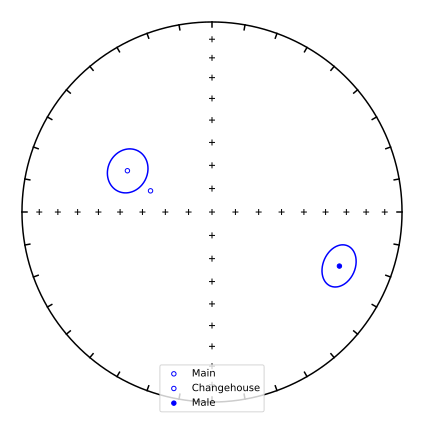

In [10]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(len(Hargraves1980a_sites['dir_dec'].tolist())):
    
    ipmag.plot_di_mean(Hargraves1980a_sites['dir_dec'][i], Hargraves1980a_sites['dir_inc'][i], 
                       Hargraves1980a_sites['dir_alpha95'][i], color = 'blue', label = Hargraves1980a_sites['note'][i])

# ipmag.plot_di_mean(Kent2015_Peddie_mean['dec'], Kent2015_Peddie_mean['inc'], Kent2015_Peddie_mean['alpha95'], color = 'blue', label = 'Peddie')

plt.legend(loc = 8)
plt.show()

In [8]:
Hargraves1980a_sites_Male = Hargraves1980a_sites[Hargraves1980a_sites['note'] == 'Male']
Hargraves1980a_sites_Male

,site,location,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_total_specimens,dir_tilt_correction,dir_alpha95,...,lithologies,method_codes,result_quality,result_type,age,age_high,age_low,age_unit,note,citations
2,3,Swartruggens,113,28,1099.0,2,2,2,0,8.0,...,kimberlite,LT-AF-Z:LP-AF-DIR:DE-BLANKET,g,i,147,151,143,Ma,Male,10.1029/jb085ib07p03587


### Hargraves (1989)

In [14]:
Hargraves1989a_sites = pd.read_csv('../Jurassic_Monster_Shift/pmag_compiled/Hargraves_1980_1989_1993_1997/Hargraves1989a_sites.txt', sep='\t',header = 1)
Hargraves1989a_sites = ipmag.vgp_calc(Hargraves1989a_sites,  tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc',)
print(Hargraves1989a_sites['vgp_lon'][0], Hargraves1989a_sites['vgp_lat'][0])

111.5414669932117 -29.588577091364737


In [20]:
Hargraves1989a_sites

,site,location,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_total_specimens,dir_tilt_correction,dir_alpha95,...,age_high,age_low,age_unit,note,citations,paleolatitude,vgp_lat,vgp_lon,vgp_lat_rev,vgp_lon_rev
0,1,Swartruggens,115.6,29.9,114,6,6,6,0,6.3,...,151,143,Ma,"Male kimberlite, 2 from Hargraves (1980) and 4...",10.1029/jb094ib02p01851,16.040618,-29.588577,111.541467,29.588577,291.541467


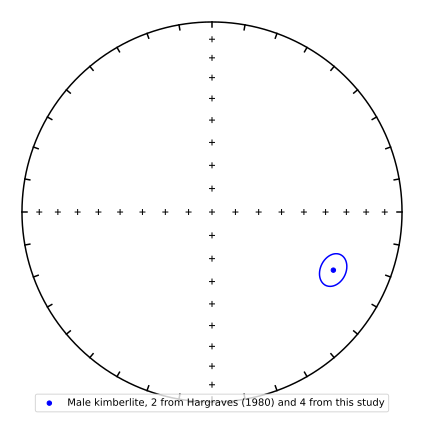

In [15]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(len(Hargraves1989a_sites['dir_dec'].tolist())):
    
    ipmag.plot_di_mean(Hargraves1989a_sites['dir_dec'][i], Hargraves1989a_sites['dir_inc'][i], 
                       Hargraves1989a_sites['dir_alpha95'][i], color = 'blue', label = Hargraves1989a_sites['note'][i])

# ipmag.plot_di_mean(Kent2015_Peddie_mean['dec'], Kent2015_Peddie_mean['inc'], Kent2015_Peddie_mean['alpha95'], color = 'blue', label = 'Peddie')

plt.legend(loc = 8)
plt.show()

6.3


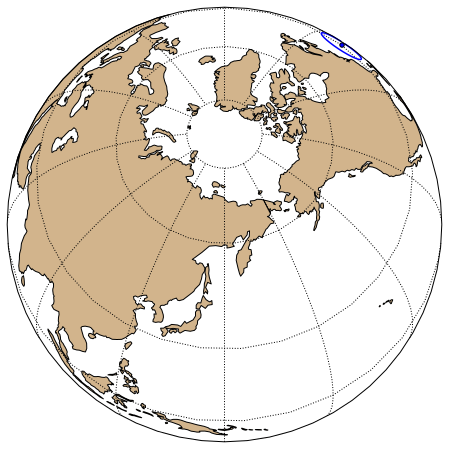

In [21]:
map_axis = ipmag.make_orthographic_map(150, 65)

ipmag.plot_pole(map_axis, Hargraves1989a_sites['vgp_lon_rev'][0], Hargraves1989a_sites['vgp_lat_rev'][0], Hargraves1989a_sites['dir_alpha95'][0], color = 'blue')
print(Hargraves1989a_sites['dir_alpha95'][0])
plt.show()

### Hargraves (1997)

In [33]:
Hargraves1997a_sites = pd.read_csv('../Jurassic_Monster_Shift/pmag_compiled/Hargraves_1980_1989_1993_1997/Hargraves1997a_sites.txt', sep='\t',header = 1)
Hargraves1997a_sites = Hargraves1997a_sites[Hargraves1997a_sites['dir_alpha95'] < 15]
Hargraves1997a_sites['dec_tc'] = [pmag.dotilt(Hargraves1997a_sites['dir_dec'].tolist()[i], Hargraves1997a_sites['dir_inc'].tolist()[i], 
                                          Hargraves1997a_sites['dir_dip'].tolist()[i],  Hargraves1997a_sites['dip'].tolist()[i])[0]
                                      for i in range(len(Hargraves1997a_sites['dir_dec']))]
Hargraves1997a_sites['inc_tc'] = [pmag.dotilt(Hargraves1997a_sites['dir_dec'].tolist()[i], Hargraves1997a_sites['dir_inc'].tolist()[i], 
                                          Hargraves1997a_sites['dir_dip'].tolist()[i],  Hargraves1997a_sites['dip'].tolist()[i])[1] 
                                      for i in range(len(Hargraves1997a_sites['dir_dec']))]

Hargraves1997a_sites = ipmag.vgp_calc(Hargraves1997a_sites,  tilt_correction='yes',
    site_lon='lon',
    site_lat='lat',
    dec_tc='dec_tc',
    inc_tc='inc_tc')
Hargraves1997a_sites

,site,location,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_total_specimens,dir_tilt_correction,dir_alpha95,...,dip,note,citations,dec_tc,inc_tc,paleolatitude,vgp_lat,vgp_lon,vgp_lat_rev,vgp_lon_rev
0,87-8,Natal,314.4,-60.3,97,7,7,7,0,6.1,...,20,Bumbeni Complex,https://journals.co.za/content/journal/10520/E...,298.831829,-44.041111,-25.805541,35.949165,289.264693,-35.949165,109.264693
1,87-9,Natal,303.1,-59.7,23,7,7,7,0,14.3,...,20,Bumbeni Complex,https://journals.co.za/content/journal/10520/E...,291.697106,-41.818324,-24.100850,29.272764,288.787442,-29.272764,108.787442
4,87-16,Natal,108.3,50.0,241,6,6,6,0,4.3,...,5,Bumbeni Complex,https://journals.co.za/content/journal/10520/E...,106.653574,45.230042,26.749529,-25.836631,104.204922,25.836631,284.204922
5,87-17,Natal,111.9,54.1,26,6,6,6,0,13.3,...,5,Bumbeni Complex,https://journals.co.za/content/journal/10520/E...,109.647905,49.423790,30.278539,-29.437103,101.346400,29.437103,281.346400


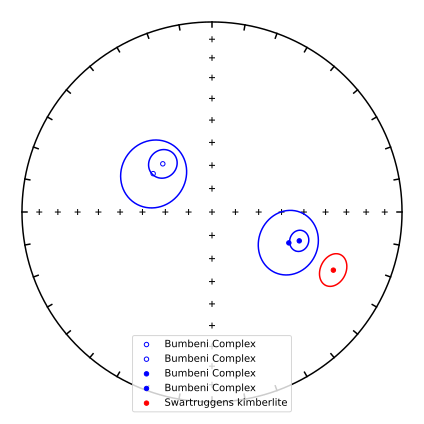

In [41]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(len(Hargraves1997a_sites['dir_dec'].tolist())):
    
    ipmag.plot_di_mean(Hargraves1997a_sites['dir_dec'].tolist()[i], Hargraves1997a_sites['dir_inc'].tolist()[i], 
                       Hargraves1997a_sites['dir_alpha95'].tolist()[i], color = 'blue', label = 'Bumbeni Complex')
    
for i in range(len(Hargraves1989a_sites['dir_dec'].tolist())):
    ipmag.plot_di_mean(Hargraves1989a_sites['dir_dec'].tolist()[i], Hargraves1989a_sites['dir_inc'].tolist()[i], 
                       Hargraves1989a_sites['dir_alpha95'].tolist()[i], color = 'red', label = 'Swartruggens kimberlite')
# ipmag.plot_di_mean(Kent2015_Peddie_mean['dec'], Kent2015_Peddie_mean['inc'], Kent2015_Peddie_mean['alpha95'], color = 'blue', label = 'Peddie')

plt.legend(loc = 8)
plt.show()

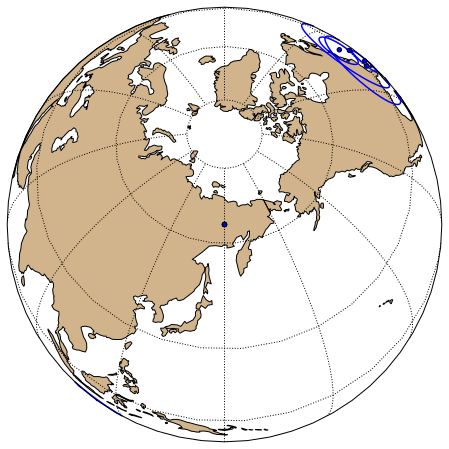

In [42]:
map_axis = ipmag.make_orthographic_map(150, 65)
for i in range(len(Hargraves1997a_sites['dir_dec'].tolist())):
    
    ipmag.plot_pole(map_axis, Hargraves1997a_sites['vgp_lon_rev'].tolist()[i], Hargraves1997a_sites['vgp_lat_rev'].tolist()[i], 
                       Hargraves1997a_sites['dir_alpha95'].tolist()[i], color = 'blue', label = 'Bumbeni Complex')
    ipmag.plot_pole(map_axis, Hargraves1997a_sites['vgp_lon'].tolist()[i], Hargraves1997a_sites['vgp_lat'].tolist()[i], 
                       Hargraves1997a_sites['dir_alpha95'].tolist()[i], color = 'blue', label = 'Bumbeni Complex')
    
plt.show()

### Combine Hargraves (1989) and (1997) 6 Swartruggens mean pole and 4 Bumbeni Complex individual poles? 

It seems to me that it makes sense to have seperate poles of Swartruggens and Bumbeni, since there are geochronology data from both units, and there is no composition association between them. Although the caveat is the date for kimberlite is Rb-Sr method which is not very accurate, and this is part of the reason that Hargraves (1997) grouped date from them with those from the Bumbeni ones. 

Below shows that the 

In [46]:
Swart_Bum_pole_dec = list()
Swart_Bum_pole_inc = list()
Swart_Bum_pole_a95 = list()

Swart_Bum_pole_lon = list()
Swart_Bum_pole_lat = list()

Swart_Bum_pole_dec.extend(Hargraves1989a_sites['dir_dec'].tolist())
Swart_Bum_pole_inc.extend(Hargraves1989a_sites['dir_inc'].tolist())
Swart_Bum_pole_dec.extend(Hargraves1997a_sites['dir_dec'].tolist())
Swart_Bum_pole_inc.extend(Hargraves1997a_sites['dir_inc'].tolist())
Swart_Bum_pole_a95.extend(Hargraves1989a_sites['dir_alpha95'])
Swart_Bum_pole_a95.extend(Hargraves1997a_sites['dir_alpha95'])

# Swart_Bum_pole_lon.extend()
# Swart_Bum_pole_lat.extend()

# Hargraves1989a_sites['dir_dec'].tolist()[i], Hargraves1989a_sites['dir_inc'].tolist()
# dec = Hargraves1997a_sites['dir_dec'].tolist(), inc = Hargraves1997a_sites['dir_inc'].tolist()

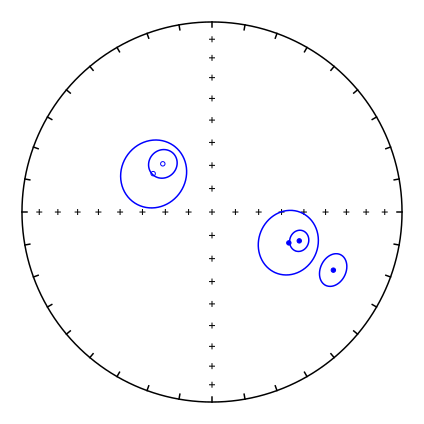

In [50]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(len(Swart_Bum_pole_dec)):
    
    ipmag.plot_di_mean(Swart_Bum_pole_dec[i], Swart_Bum_pole_inc[i], Swart_Bum_pole_a95[i], color = 'blue')


# plt.legend(loc = 8)
plt.show()

In [52]:
Hargraves1997a_sites_dir_flip_dec = list()
Hargraves1997a_sites_dir_flip_inc = list()

for i in range (len(Swart_Bum_pole_dec)):
    this_dec = Swart_Bum_pole_dec[i]
    this_inc = Swart_Bum_pole_inc[i]
    
    if this_inc < 0:
        this_inc = -this_inc
        this_dec = this_dec - 180
    Hargraves1997a_sites_dir_flip_dec.append(this_dec)
    Hargraves1997a_sites_dir_flip_inc.append(this_inc)


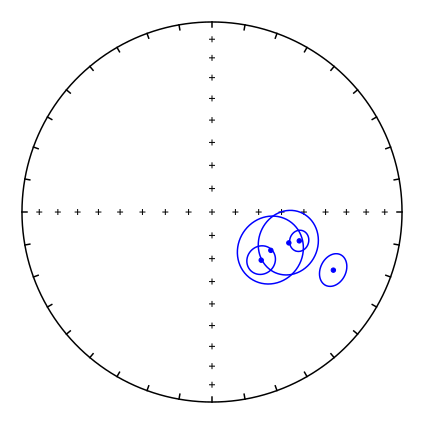

In [53]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(len(Hargraves1997a_sites_dir_flip_dec)):
    
    ipmag.plot_di_mean(Hargraves1997a_sites_dir_flip_dec[i], Hargraves1997a_sites_dir_flip_inc[i], Swart_Bum_pole_a95[i], color = 'blue')


# plt.legend(loc = 8)
plt.show()

**I would argue for separate poles for Swartruggens and Bumbeni**

In [50]:
Kent_2010_160_Ma = [78.5, 112.5, 7.5]

# Plotting all poles

In [160]:
pole_means.to_csv('pmag_compiled/compiled_monster_poles.csv')
pole_means

,PoleName,SLat,SLon,PLat,PLon,A95,K,N,PolarityZone,PmagRef,AgeNominal,AgeLower,AgeUpper,AgeInfo,AgeRef,Gaussian_2sigma,GaussianOrUniform,Q,color
Ithaca kimberlites,Ithaca kimberlites,42.500,283.500,58.100000,203.100000,3.800000,256.900000,7,Ithaca normal and reversed,"VanFossen & Kent, 1993",142.0,138.0,146.0,K-Ar date on kimberlite dikes yielding 142 $\p...,"Basu et al., 1984",4.0,Gaussian,0,C3
Peddie_kimberlite,Peddie kimberlites,47.443,280.318,73.500000,184.100000,3.700000,83.700000,19,Peddie normal,"Kent et al., 2015",154.9,153.8,156.0,U-Pb date on perovskite from kimberlite yieldi...,"Kent et al., 2015",1.1,Gaussian,0,C2
Triple_B_kimberlite,Triple B kimberlites,47.454,280.238,77.900000,198.900000,4.100000,86.100000,15,Triple B reversed,"Kent et al., 2015",157.5,156.3,158.7,U-Pb date on perovskite from kimberlite yieldi...,"Kent et al., 2015",1.2,Gaussian,0,C2
Moat_volcanics,Moat Volcanics,47.443,44.080,78.700000,90.300000,7.400000,39.800000,9,Moat early reversed,"Van-Fossen & Kent, 1990",169.0,161.0,177.0,Rb-Sr age fro mplutonic rocks associated with ...,"VanFossen & Kent, 1990",8.0,Gaussian,0,C0
Anticosti_2_dikes,Anticosti dikes,49.800,296.800,84.700000,75.700000,1.040000,18121.301775,"0 2 Name: dir_n_sites, dtype: int64",Anticosti normal,"Larochelle, 1971",183.0,171.5,194.5,not sure what dating method was used,"Larochelle, 1971",11.5,Gaussian,0,C0
Newark_volcanics,Newark Supergroup Volcanics,42.614,287.449,65.274193,102.205834,2.840544,329.491245,9,Newark normal,"Prevot & McWilliams, 1989",189.0,194.0,185.0,a broad estimate based on several studies,"de Boer, 1968; Armstrong and Besancon, 1970; S...",5.0,Gaussian,0,C0


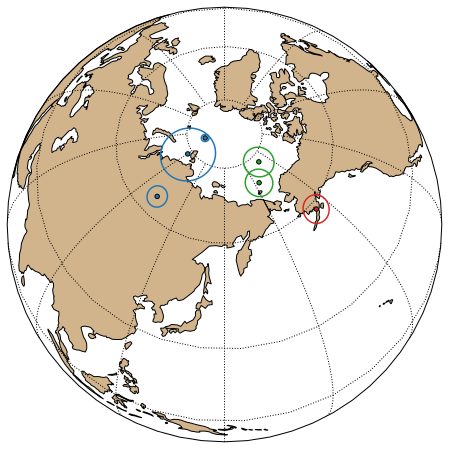

In [161]:
map_axis = ipmag.make_orthographic_map(150, 65)

for i in range(len(pole_means['PoleName'])):
    ipmag.plot_pole(map_axis, pole_means['PLon'][i], pole_means['PLat'][i], pole_means['A95'][i], color = pole_means['color'][i], label = pole_means['PoleName'][i])

plt.show()